# Import Libraries and Dataset

In [ ]:
import numpy as np
import os
import random
import pandas as pd
import matplotlib.pyplot as plt

#Preprocessing and Modelling
! pip install imbalanced-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix, accuracy_score, classification_report, precision_recall_fscore_support, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold
from imblearn.under_sampling import RandomUnderSampler

%tensorflow_version 2.x
!pip install tensorflow-determinism
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, AlphaDropout, LeakyReLU
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.backend import sigmoid
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.optimizers import Adam, Nadam, Adagrad, SGD, RMSprop, Adadelta

# %%capture
!pip install -U keras-tuner
import kerastuner as kt
from kerastuner.tuners import RandomSearch, BayesianOptimization, Sklearn
from sklearn import metrics

#Setting seeds and random states for reproducibility
# 
SEED = 0
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED']=str(SEED)
# tf.keras.backend.clear_session()
# tf.compat.v1.reset_default_graph()
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

#Checking GPU availability
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device usage is not active')
else:
  print('Found GPU at: {}'.format(device_name))

#Swish activation function
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))
get_custom_objects().update({'swish': swish})

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


  Created wheel for tensorflow-determinism: filename=tensorflow_determinism-0.3.0-py3-none-any.whl size=9156 sha256=425c9e7bb1b80dcee21ed0bf8cd2ba619aa0707e990c8577a3c2e62d8841968e
  Stored in directory: /root/.cache/pip/wheels/d2/be/33/2b27e81e5d40b4bfb7c103ac6c6c5e81fdbcf40d2af5078529
Successfully built tensorflow-determinism
     |████████████████████████████████| 96 kB 2.6 MB/s 
GPU device usage is not active


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [ ]:
np.random.seed(0)

In [ ]:
X, y = np.arange(10).reshape((5, 2)), range(5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train)

[[2 3]
 [6 7]
 [8 9]]


# Prepare The Dataset

## Sample The Dataset
1 Positive Sample : 5 Negative Sample => train-interactions.csv
the rest => unknown-interactions.csv

In [ ]:
interactions = pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/interactions.csv')
print(interactions.shape)
interactions.head()

(131036, 4)


,Unnamed: 0,uniprot_id,pubchemID,interaction
0,0,HDAC3_HUMAN,24853793,1
1,1,HDAC3_HUMAN,11700059,1
2,2,HDAC3_HUMAN,6918878,1
3,3,HDAC3_HUMAN,2746,1
4,4,HDAC3_HUMAN,467801,1


In [ ]:
interactions['interaction'].value_counts()

0    123134
1      7902
Name: interaction, dtype: int64

In [ ]:
# TRAIN DATASET
X = interactions.drop('interaction', axis=1)
y = interactions['interaction']

sampler = RandomUnderSampler(random_state=42, sampling_strategy=0.2)
X_res, y_res = sampler.fit_resample(X, y)
train_interactions = pd.concat([pd.DataFrame(X_res, columns=X.columns), pd.Series(y_res, name='interaction')], axis=1)

print(train_interactions.shape)
print()
print(train_interactions['interaction'].value_counts())

train_interactions.to_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/train-interactions.csv', index=False)

train_interactions.head()

(47412, 4)

0    39510
1     7902
Name: interaction, dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


,Unnamed: 0,uniprot_id,pubchemID,interaction
0,53079,VEGFA_HUMAN,44219631,0
1,83946,MMP12_HUMAN,44293185,0
2,55917,TNFA_HUMAN,5311297,0
3,88108,B2MG_HUMAN,44442174,0
4,43477,IL8_HUMAN,6419347,0


In [ ]:
unknown_interactions = pd.concat([interactions, train_interactions], axis=0).drop_duplicates(keep=False)
unknown_interactions.to_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/test-interactions.csv', index=False)
print(unknown_interactions.shape)
unknown_interactions.head()

(83624, 4)


,Unnamed: 0,uniprot_id,pubchemID,interaction
7903,241,HDAC3_HUMAN,513441,0
7904,242,HDAC3_HUMAN,24193271,0
7906,244,HDAC3_HUMAN,44333466,0
7907,245,HDAC3_HUMAN,9810043,0
7908,246,HDAC3_HUMAN,10818236,0


## Train Data (Undersampling)

In [ ]:
train_interactions = pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/train-interactions.csv')
train_interactions['uniprot_id'].unique()

array(['VEGFA_HUMAN', 'MMP12_HUMAN', 'TNFA_HUMAN', 'B2MG_HUMAN',
       'IL8_HUMAN', 'RASH_HUMAN', 'EGFR_HUMAN', 'TF65_HUMAN',
       'SDF1_HUMAN', 'LOX5_HUMAN', 'IL1B_HUMAN', 'IFNG_HUMAN',
       'PGH2_HUMAN', 'IL6_HUMAN', 'HMOX1_HUMAN', 'PERM_HUMAN',
       'HDAC3_HUMAN'], dtype=object)

In [ ]:
train_interactions = pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/train-interactions.csv')
print(train_interactions.shape)
train_interactions.head()

(47412, 4)


,Unnamed: 0,uniprot_id,pubchemID,interaction
0,53079,VEGFA_HUMAN,44219631,0
1,83946,MMP12_HUMAN,44293185,0
2,55917,TNFA_HUMAN,5311297,0
3,88108,B2MG_HUMAN,44442174,0
4,43477,IL8_HUMAN,6419347,0


In [ ]:
print(train_interactions['uniprot_id'].unique().shape)
print(train_interactions['pubchemID'].unique().shape)
print(47412)

(17,)
(7708,)
47412


In [ ]:
train_interactions['interaction'].value_counts()

0    39510
1     7902
Name: interaction, dtype: int64

## FP

In [ ]:
train_fp = pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/com-train-fp.csv')
print(train_fp.shape)
train_fp.head()

(7708, 883)


,drug,pubchemID,>=_4_H,>=_8_H,>=_16_H,>=_32_H,>=_1_Li,>=_2_Li,>=_1_B,>=_2_B,>=_4_B,>=_2_C,>=_4_C,>=_8_C,>=_16_C,>=_32_C,>=_1_N,>=_2_N,>=_4_N,>=_8_N,>=_1_O,>=_2_O,>=_4_O,>=_8_O,>=_16_O,>=_1_F,>=_2_F,>=_4_F,>=_1_Na,>=_2_Na,>=_1_Si,>=_2_Si,>=_1_P,>=_2_P,>=_4_P,>=_1_S,>=_2_S,>=_4_S,>=_8_S,>=_1_Cl,...,CC1CC(S)CC1,CC1CC(N)CC1,CC1CC(Cl)CC1,CC1CC(Br)CC1,OC1CC(O)CC1,OC1CC(S)CC1,OC1CC(N)CC1,OC1CC(Cl)CC1,OC1CC(Br)CC1,SC1CC(S)CC1,SC1CC(N)CC1,SC1CC(Cl)CC1,SC1CC(Br)CC1,NC1CC(N)CC1,NC1CC(Cl)CC1,NC1CC(Br)CC1,ClC1CC(Cl)CC1,ClC1CC(Br)CC1,BrC1CC(Br)CC1,CC1C(C)CCC1,CC1C(O)CCC1,CC1C(S)CCC1,CC1C(N)CCC1,CC1C(Cl)CCC1,CC1C(Br)CCC1,OC1C(O)CCC1,OC1C(S)CCC1,OC1C(N)CCC1,OC1C(Cl)CCC1,OC1C(Br)CCC1,SC1C(S)CCC1,SC1C(N)CCC1,SC1C(Cl)CCC1,SC1C(Br)CCC1,NC1C(N)CCC1,NC1C(Cl)CC1,NC1C(Br)CCC1,ClC1C(Cl)CCC1,ClC1C(Br)CCC1,BrC1C(Br)CCC1
0,"4-phenylimidazole, 17",24853793,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"4-phenylimidazole, 19",11700059,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,AC1OCG0B,6918878,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Acetyldinaline,2746,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,apicidin,467801,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## FP-AAC

In [ ]:
aac = pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/prot-aac.csv')
print(aac.shape)
aac.head()

(17, 21)


,aac_1,aac_2,aac_3,aac_4,aac_5,aac_6,aac_7,aac_8,aac_9,aac_10,aac_11,aac_12,aac_13,aac_14,aac_15,aac_16,aac_17,aac_18,aac_19,aac_20,uniprot_id
0,0.050420,0.016807,0.061983,0.035047,0.020833,0.054217,0.044610,0.063197,0.061321,0.040404,0.087537,0.074468,0.022819,0.044702,0.044702,0.058201,0.021505,0.047187,0.055794,0.034483,B2MG_HUMAN
1,0.050420,0.050420,0.069421,0.018692,0.024306,0.060241,0.074349,0.084906,0.004717,0.050505,0.056380,0.029787,0.046980,0.048013,0.057947,0.058201,0.032258,0.078040,0.072961,0.077586,EGFR_HUMAN
2,0.042017,0.075630,0.052893,0.058411,0.114583,0.042169,0.018587,0.042453,0.014151,0.070707,0.023739,0.053191,0.045638,0.043046,0.058201,0.000000,0.043011,0.032668,0.017167,0.068966,HDAC3_HUMAN
3,0.058824,0.059504,0.010744,0.049065,0.055556,0.012048,0.078067,0.051887,0.037736,0.030303,0.051929,0.085106,0.060403,0.021523,0.063492,0.047619,0.043011,0.018149,0.051502,0.056034,HMOX1_HUMAN
4,0.016807,0.049587,0.029752,0.051402,0.027778,0.054217,0.066914,0.037736,0.101010,0.010101,0.050445,0.070213,0.009396,0.059603,0.026455,0.084656,0.021505,0.041742,0.128755,0.060345,IFNG_HUMAN


In [ ]:
fp_aac = train_interactions.merge(aac, on='uniprot_id')
fp_aac = fp_aac.merge(train_fp, on='pubchemID')
fp_aac = fp_aac.drop('Unnamed: 0', axis=1)

fp_aac.to_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/train-fp-aac.csv', index=False)

print(fp_aac.shape)
fp_aac.head()

(47412, 905)


,uniprot_id,pubchemID,interaction,aac_1,aac_2,aac_3,aac_4,aac_5,aac_6,aac_7,aac_8,aac_9,aac_10,aac_11,aac_12,aac_13,aac_14,aac_15,aac_16,aac_17,aac_18,aac_19,aac_20,drug,>=_4_H,>=_8_H,>=_16_H,>=_32_H,>=_1_Li,>=_2_Li,>=_1_B,>=_2_B,>=_4_B,>=_2_C,>=_4_C,>=_8_C,>=_16_C,>=_32_C,>=_1_N,>=_2_N,...,CC1CC(S)CC1,CC1CC(N)CC1,CC1CC(Cl)CC1,CC1CC(Br)CC1,OC1CC(O)CC1,OC1CC(S)CC1,OC1CC(N)CC1,OC1CC(Cl)CC1,OC1CC(Br)CC1,SC1CC(S)CC1,SC1CC(N)CC1,SC1CC(Cl)CC1,SC1CC(Br)CC1,NC1CC(N)CC1,NC1CC(Cl)CC1,NC1CC(Br)CC1,ClC1CC(Cl)CC1,ClC1CC(Br)CC1,BrC1CC(Br)CC1,CC1C(C)CCC1,CC1C(O)CCC1,CC1C(S)CCC1,CC1C(N)CCC1,CC1C(Cl)CCC1,CC1C(Br)CCC1,OC1C(O)CCC1,OC1C(S)CCC1,OC1C(N)CCC1,OC1C(Cl)CCC1,OC1C(Br)CCC1,SC1C(S)CCC1,SC1C(N)CCC1,SC1C(Cl)CCC1,SC1C(Br)CCC1,NC1C(N)CCC1,NC1C(Cl)CC1,NC1C(Br)CCC1,ClC1C(Cl)CCC1,ClC1C(Br)CCC1,BrC1C(Br)CCC1
0,VEGFA_HUMAN,44219631,0,0.042017,0.029752,0.081776,0.041667,0.018072,0.022305,0.029740,0.089623,0.010101,0.065282,0.029787,0.048322,0.051325,0.009934,0.031746,0.107527,0.016334,0.068670,0.030172,0.047414,CHEMBL466863,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,SDF1_HUMAN,44219631,0,0.042017,0.091736,0.074766,0.000000,0.048193,0.042169,0.078067,0.028302,0.060606,0.045994,0.059574,0.076510,0.016107,0.066225,0.058201,0.021505,0.058076,0.030043,0.068670,0.025862,CHEMBL466863,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,LOX5_HUMAN,44219631,0,0.033613,0.063636,0.049065,0.067757,0.055556,0.066265,0.089219,0.033019,0.050505,0.053412,0.044510,0.061702,0.030872,0.056291,0.058201,0.021505,0.085299,0.001815,0.064378,0.090517,CHEMBL466863,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,IL1B_HUMAN,44219631,0,0.075630,0.054545,0.057851,0.042056,0.045139,0.084337,0.048327,0.018868,0.060606,0.010101,0.048961,0.025532,0.040268,0.051325,0.079365,0.075269,0.010753,0.132486,0.034335,0.047414,CHEMBL466863,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,PGH2_HUMAN,44219631,1,0.067227,0.025620,0.063084,0.027778,0.065972,0.036145,0.074349,0.132075,0.030303,0.019288,0.044681,0.048936,0.063087,0.024834,0.058201,0.032258,0.059891,0.081545,0.008584,0.064655,CHEMBL466863,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
fp_aac = pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/train-fp-aac.csv')
fp_aac = fp_aac.drop(['uniprot_id', 'pubchemID', 'drug'], axis=1)

X = fp_aac.drop('interaction', axis=1)
y = fp_aac.interaction

print(X.shape, y.shape)

(47412, 901) (47412,)


In [ ]:
fp_aac.head()

,interaction,aac_1,aac_2,aac_3,aac_4,aac_5,aac_6,aac_7,aac_8,aac_9,aac_10,aac_11,aac_12,aac_13,aac_14,aac_15,aac_16,aac_17,aac_18,aac_19,aac_20,>=_4_H,>=_8_H,>=_16_H,>=_32_H,>=_1_Li,>=_2_Li,>=_1_B,>=_2_B,>=_4_B,>=_2_C,>=_4_C,>=_8_C,>=_16_C,>=_32_C,>=_1_N,>=_2_N,>=_4_N,>=_8_N,>=_1_O,...,CC1CC(S)CC1,CC1CC(N)CC1,CC1CC(Cl)CC1,CC1CC(Br)CC1,OC1CC(O)CC1,OC1CC(S)CC1,OC1CC(N)CC1,OC1CC(Cl)CC1,OC1CC(Br)CC1,SC1CC(S)CC1,SC1CC(N)CC1,SC1CC(Cl)CC1,SC1CC(Br)CC1,NC1CC(N)CC1,NC1CC(Cl)CC1,NC1CC(Br)CC1,ClC1CC(Cl)CC1,ClC1CC(Br)CC1,BrC1CC(Br)CC1,CC1C(C)CCC1,CC1C(O)CCC1,CC1C(S)CCC1,CC1C(N)CCC1,CC1C(Cl)CCC1,CC1C(Br)CCC1,OC1C(O)CCC1,OC1C(S)CCC1,OC1C(N)CCC1,OC1C(Cl)CCC1,OC1C(Br)CCC1,SC1C(S)CCC1,SC1C(N)CCC1,SC1C(Cl)CCC1,SC1C(Br)CCC1,NC1C(N)CCC1,NC1C(Cl)CC1,NC1C(Br)CCC1,ClC1C(Cl)CCC1,ClC1C(Br)CCC1,BrC1C(Br)CCC1
0,0,0.042017,0.029752,0.081776,0.041667,0.018072,0.022305,0.029740,0.089623,0.010101,0.065282,0.029787,0.048322,0.051325,0.009934,0.031746,0.107527,0.016334,0.068670,0.030172,0.047414,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0.042017,0.091736,0.074766,0.000000,0.048193,0.042169,0.078067,0.028302,0.060606,0.045994,0.059574,0.076510,0.016107,0.066225,0.058201,0.021505,0.058076,0.030043,0.068670,0.025862,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0.033613,0.063636,0.049065,0.067757,0.055556,0.066265,0.089219,0.033019,0.050505,0.053412,0.044510,0.061702,0.030872,0.056291,0.058201,0.021505,0.085299,0.001815,0.064378,0.090517,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0.075630,0.054545,0.057851,0.042056,0.045139,0.084337,0.048327,0.018868,0.060606,0.010101,0.048961,0.025532,0.040268,0.051325,0.079365,0.075269,0.010753,0.132486,0.034335,0.047414,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0.067227,0.025620,0.063084,0.027778,0.065972,0.036145,0.074349,0.132075,0.030303,0.019288,0.044681,0.048936,0.063087,0.024834,0.058201,0.032258,0.059891,0.081545,0.008584,0.064655,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## FP-DC

In [ ]:
dc = pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/prot-dc.csv')
print(dc.shape)
dc.head()

(17, 401)


,dc_1,dc_2,dc_3,dc_4,dc_5,dc_6,dc_7,dc_8,dc_9,dc_10,dc_11,dc_12,dc_13,dc_14,dc_15,dc_16,dc_17,dc_18,dc_19,dc_20,dc_21,dc_22,dc_23,dc_24,dc_25,dc_26,dc_27,dc_28,dc_29,dc_30,dc_31,dc_32,dc_33,dc_34,dc_35,dc_36,dc_37,dc_38,dc_39,dc_40,...,dc_362,dc_363,dc_364,dc_365,dc_366,dc_367,dc_368,dc_369,dc_370,dc_371,dc_372,dc_373,dc_374,dc_375,dc_376,dc_377,dc_378,dc_379,dc_380,dc_381,dc_382,dc_383,dc_384,dc_385,dc_386,dc_387,dc_388,dc_389,dc_390,dc_391,dc_392,dc_393,dc_394,dc_395,dc_396,dc_397,dc_398,dc_399,dc_400,uniprot_id
0,0.0,0.000000,0.000000,0.008475,0.000000,0.0,0.000000,0.008475,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.008475,0.002481,0.003309,0.003309,0.001654,0.003309,0.000000,0.007444,0.002481,0.000827,0.000827,0.001654,0.005790,0.000827,0.004136,0.000827,0.003309,...,0.00000,0.00000,0.0,0.000000,0.008621,0.00000,0.0,0.0,0.00000,0.004310,0.004310,0.00000,0.0,0.0,0.00431,0.00000,0.000000,0.004329,0.000000,0.000000,0.000000,0.008658,0.000000,0.004329,0.008658,0.004329,0.004329,0.000000,0.008658,0.000000,0.000000,0.0,0.004329,0.004329,0.000000,0.000000,0.000000,0.000000,0.004329,B2MG_HUMAN
1,0.0,0.008475,0.016949,0.000000,0.000000,0.0,0.008475,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.008475,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.002481,0.003309,0.003309,0.003309,0.000000,0.000827,0.007444,0.001654,0.005790,0.000827,0.000827,0.002481,0.004963,0.004136,0.001654,0.000000,...,0.00431,0.00431,0.0,0.004310,0.012931,0.00431,0.0,0.0,0.00000,0.008621,0.000000,0.00431,0.0,0.0,0.00000,0.00000,0.004329,0.000000,0.004329,0.000000,0.000000,0.008658,0.000000,0.000000,0.004329,0.000000,0.000000,0.000000,0.004329,0.012987,0.000000,0.0,0.000000,0.008658,0.000000,0.000000,0.000000,0.000000,0.008658,EGFR_HUMAN
2,0.0,0.008475,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.016949,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.008475,0.0,0.000000,0.0,0.000000,0.000000,0.004963,0.003309,0.002481,0.004963,0.002481,0.005790,0.000827,0.004963,0.002481,0.001654,0.000827,0.000827,0.004963,0.004136,0.000000,0.004136,...,0.00000,0.00431,0.0,0.012931,0.004310,0.00000,0.0,0.0,0.00431,0.000000,0.008621,0.00431,0.0,0.0,0.00431,0.00431,0.004329,0.000000,0.000000,0.004329,0.004329,0.008658,0.000000,0.004329,0.012987,0.004329,0.004329,0.004329,0.008658,0.000000,0.004329,0.0,0.004329,0.000000,0.017316,0.004329,0.004329,0.000000,0.004329,HDAC3_HUMAN
3,0.0,0.000000,0.000000,0.000000,0.016949,0.0,0.000000,0.000000,0.0,0.000000,0.008475,0.000000,0.008475,0.000000,0.000000,0.0,0.016949,0.0,0.000000,0.0,0.008475,0.0,0.000000,0.000000,0.001654,0.001654,0.007444,0.000000,0.002481,0.004963,0.001654,0.004963,0.000827,0.004136,0.002481,0.001654,0.006617,0.000000,0.000827,0.000827,...,0.00431,0.00000,0.0,0.000000,0.000000,0.00431,0.0,0.0,0.00000,0.004310,0.017241,0.00000,0.0,0.0,0.00000,0.00000,0.004329,0.000000,0.004329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004329,0.000000,0.004329,0.004329,0.008658,0.0,0.000000,0.004329,0.000000,0.000000,0.000000,0.000000,0.000000,HMOX1_HUMAN
4,0.0,0.000000,0.000000,0.008475,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.016949,0.000000,0.016949,0.000000,0.0,0.000000,0.0,0.033898,0.0,0.000000,0.0,0.008475,0.008475,0.002481,0.001654,0.001654,0.001654,0.001654,0.000827,0.006617,0.000827,0.002481,0.000827,0.003309,0.001654,0.001654,0.003309,0.003309,0.001654,...,0.00000,0.00000,0.0,0.004310,0.000000,0.00000,0.0,0.0,0.00000,0.000000,0.004310,0.00431,0.0,0.0,0.00431,0.00000,0.000000,0.000000,0.000000,0.004329,0.017316,0.004329,0.004329,0.004329,0.004329,0.008658,0.004329,0.004329,0.000000,0.004329,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.004329,0.000000,IFNG_HUMAN


In [ ]:
fp_dc = train_interactions.merge(dc, on='uniprot_id')
fp_dc = fp_dc.merge(train_fp, on='pubchemID')
fp_dc = fp_dc.drop('Unnamed: 0', axis=1)

fp_dc.to_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/train-fp-dc.csv', index=False)

print(fp_dc.shape)
fp_dc.head()

(47412, 1285)


,uniprot_id,pubchemID,interaction,dc_1,dc_2,dc_3,dc_4,dc_5,dc_6,dc_7,dc_8,dc_9,dc_10,dc_11,dc_12,dc_13,dc_14,dc_15,dc_16,dc_17,dc_18,dc_19,dc_20,dc_21,dc_22,dc_23,dc_24,dc_25,dc_26,dc_27,dc_28,dc_29,dc_30,dc_31,dc_32,dc_33,dc_34,dc_35,dc_36,dc_37,...,CC1CC(S)CC1,CC1CC(N)CC1,CC1CC(Cl)CC1,CC1CC(Br)CC1,OC1CC(O)CC1,OC1CC(S)CC1,OC1CC(N)CC1,OC1CC(Cl)CC1,OC1CC(Br)CC1,SC1CC(S)CC1,SC1CC(N)CC1,SC1CC(Cl)CC1,SC1CC(Br)CC1,NC1CC(N)CC1,NC1CC(Cl)CC1,NC1CC(Br)CC1,ClC1CC(Cl)CC1,ClC1CC(Br)CC1,BrC1CC(Br)CC1,CC1C(C)CCC1,CC1C(O)CCC1,CC1C(S)CCC1,CC1C(N)CCC1,CC1C(Cl)CCC1,CC1C(Br)CCC1,OC1C(O)CCC1,OC1C(S)CCC1,OC1C(N)CCC1,OC1C(Cl)CCC1,OC1C(Br)CCC1,SC1C(S)CCC1,SC1C(N)CCC1,SC1C(Cl)CCC1,SC1C(Br)CCC1,NC1C(N)CCC1,NC1C(Cl)CC1,NC1C(Br)CCC1,ClC1C(Cl)CCC1,ClC1C(Br)CCC1,BrC1C(Br)CCC1
0,VEGFA_HUMAN,44219631,0,0.000000,0.000000,0.008475,0.000000,0.000000,0.0,0.000000,0.008475,0.0,0.000000,0.000000,0.016949,0.000000,0.000000,0.000000,0.0,0.016949,0.0,0.000000,0.008475,0.000000,0.008475,0.000000,0.008271,0.004136,0.004963,0.000827,0.004963,0.000000,0.000827,0.002481,0.003309,0.001654,0.000000,0.002481,0.003309,0.000827,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,SDF1_HUMAN,44219631,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.008475,0.016949,0.000000,0.016949,0.000000,0.0,0.000000,0.0,0.008475,0.000000,0.000000,0.008475,0.000000,0.002481,0.003309,0.000827,0.005790,0.003309,0.002481,0.003309,0.000000,0.005790,0.001654,0.003309,0.004963,0.002481,0.003309,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,LOX5_HUMAN,44219631,0,0.000000,0.008475,0.000000,0.008475,0.000000,0.0,0.008475,0.000000,0.0,0.008475,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.008475,0.000000,0.000000,0.008475,0.000000,0.000000,0.002481,0.002481,0.004136,0.003309,0.000827,0.005790,0.001654,0.000827,0.000827,0.000000,0.002481,0.003309,0.002481,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,IL1B_HUMAN,44219631,0,0.008475,0.000000,0.000000,0.000000,0.000000,0.0,0.008475,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.008475,0.0,0.000000,0.0,0.008475,0.000000,0.000000,0.000000,0.008475,0.000000,0.000000,0.004136,0.003309,0.000827,0.000827,0.000000,0.002481,0.000000,0.004136,0.001654,0.001654,0.011580,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,PGH2_HUMAN,44219631,1,0.000000,0.000000,0.008475,0.000000,0.008475,0.0,0.000000,0.000000,0.0,0.000000,0.008475,0.000000,0.008475,0.000000,0.000000,0.0,0.000000,0.0,0.008475,0.008475,0.008475,0.000000,0.008475,0.001654,0.004963,0.000000,0.000827,0.004136,0.004136,0.001654,0.000000,0.002481,0.005790,0.000827,0.004963,0.002481,0.000827,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
fp_dc = pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/train-fp-dc.csv')
fp_dc = fp_dc.drop(['uniprot_id', 'pubchemID', 'drug'], axis=1)

X = fp_dc.drop('interaction', axis=1)
y = fp_dc.interaction

print(X.shape, y.shape)

(47412, 1281) (47412,)


In [ ]:
881 + 400 | 1

1282

## FP-QSO

In [ ]:
qso = pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/prot-qso.csv')
print(qso.shape)
qso.head()

(17, 8001)


,tc_1,tc_2,tc_3,tc_4,tc_5,tc_6,tc_7,tc_8,tc_9,tc_10,tc_11,tc_12,tc_13,tc_14,tc_15,tc_16,tc_17,tc_18,tc_19,tc_20,tc_21,tc_22,tc_23,tc_24,tc_25,tc_26,tc_27,tc_28,tc_29,tc_30,tc_31,tc_32,tc_33,tc_34,tc_35,tc_36,tc_37,tc_38,tc_39,tc_40,...,tc_7962,tc_7963,tc_7964,tc_7965,tc_7966,tc_7967,tc_7968,tc_7969,tc_7970,tc_7971,tc_7972,tc_7973,tc_7974,tc_7975,tc_7976,tc_7977,tc_7978,tc_7979,tc_7980,tc_7981,tc_7982,tc_7983,tc_7984,tc_7985,tc_7986,tc_7987,tc_7988,tc_7989,tc_7990,tc_7991,tc_7992,tc_7993,tc_7994,tc_7995,tc_7996,tc_7997,tc_7998,tc_7999,tc_8000,uniprot_id
0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0.0,0,0,0,0.0,0,0,0,0,0.0,0,0.000000,0,0,0,0,0.000000,0.0,0,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0.0,0.000000,0,0,0,0.0,0.0,0.000000,0,0,0,0,0,0,0.000000,0,0,0.0,0,0.0,0.000000,0,0.0,0.0,0.000000,B2MG_HUMAN
1,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0.0,0,0,0,0.0,0,0,0,0,0.0,0,0.000000,0,0,0,0,0.008547,0.0,0,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0.0,0.000000,0,0,0,0.0,0.0,0.004348,0,0,0,0,0,0,0.000000,0,0,0.0,0,0.0,0.000000,0,0.0,0.0,0.000000,EGFR_HUMAN
2,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0.0,0,0,0,0.0,0,0,0,0,0.0,0,0.000000,0,0,0,0,0.000000,0.0,0,0.008547,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0.0,0.000000,0,0,0,0.0,0.0,0.000000,0,0,0,0,0,0,0.000000,0,0,0.0,0,0.0,0.004348,0,0.0,0.0,0.004348,HDAC3_HUMAN
3,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0.0,0,0,0,0.0,0,0,0,0,0.0,0,0.000000,0,0,0,0,0.000000,0.0,0,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0.0,0.004348,0,0,0,0.0,0.0,0.000000,0,0,0,0,0,0,0.004348,0,0,0.0,0,0.0,0.000000,0,0.0,0.0,0.000000,HMOX1_HUMAN
4,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0.0,0,0,0,0.0,0,0,0,0,0.0,0,0.008547,0,0,0,0,0.008547,0.0,0,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0.0,0.000000,0,0,0,0.0,0.0,0.000000,0,0,0,0,0,0,0.000000,0,0,0.0,0,0.0,0.000000,0,0.0,0.0,0.000000,IFNG_HUMAN


In [ ]:
fp_qso = train_interactions.merge(qso, on='uniprot_id')
fp_qso = fp_qso.merge(train_fp, on='pubchemID')
fp_qso = fp_qso.drop('Unnamed: 0', axis=1)

fp_qso.to_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/train-fp-qso.csv', index=False)

print(fp_qso.shape)
fp_qso.head()

In [ ]:
fp_qso = pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/train-fp-qso.csv')
fp_qso = fp_qso.drop(['uniprot_id', 'pubchemID', 'drug'], axis=1)

X = fp_qso.drop('interaction', axis=1)
y = fp_qso.interaction

print(X.shape, y.shape)

(47412, 1281) (47412,)


In [ ]:
881 + 100 + 1

1282

# The Model

## SAE Model

In [ ]:
def sae_model(xt, xv = None, EPOCHS = 50, BATCH_SIZE = 32, opt = "adam", fr_node = 0.5, hl_node = 1024, lr = 0.01,af = "relu",num_layers = 3, do = 0.1, verbose = 0,return_fe = False):
  #Setting result placeholders
  xt_ae = []; xv_ae = []; w_ae = []
  #If validation set is not present, use train set as validation set
  if xv is None :
    xv = xt.copy()
  opt = tf.keras.optimizers.get(opt) #Set optimizer
  K.set_value(opt.learning_rate, lr) #Set learning rate

  #Stacked Autoencoder architecture
  for n_layers in range(num_layers):
    #Autoencoder
    inp = Input(shape=(xt.shape[1],))
    hidden_layer = Dropout(0.1)(inp)
    enc = Dense(int(hl_node*(fr_node**n_layers)), activation = af)(hidden_layer)  
    dec = Dense(xt.shape[1],activation="linear")(enc)
    ae = Model(inp, dec)

    ae.compile(optimizer=opt, loss='mean_squared_error')
    es = EarlyStopping(monitor='val_loss', patience=15, verbose=verbose)
    ae.fit(xt, xt, 
           epochs=EPOCHS,batch_size=BATCH_SIZE, 
           shuffle=True, callbacks = [es] , verbose = verbose,
           validation_data = (xv,xv))

    fe = Model(ae.input, enc)
    xt = fe.predict(xt) ; xt_ae.append(xt)
    xv = fe.predict(xv) ; xv_ae.append(xv)
    w_ae.append([layer_name for layer_name in ae.layers if "dense" in layer_name.name][0].get_weights())
    if verbose:
      print("Layer {} trained".format(n_layers+1))

  return (w_ae,xv) if return_fe else w_ae

## DNN Model

In [ ]:
def dnn_model(xt, sae_weights = None, EPOCHS = 50,BATCH_SIZE = 32, opt = "adam", hl_node = 1024, lr = 0.01,af = "relu",num_layers = 3, do=0, fr_node = 0.5):
  opt = tf.keras.optimizers.get(opt) #Set optimizer
  K.set_value(opt.learning_rate, lr) #Set learning rate
  
  #Model architecture
  input_layer = Input(shape=(xt.shape[1],))
  hidden_layer = BatchNormalization()(input_layer)
  hidden_layer = Dropout(do)(hidden_layer)
  for n_layers in range(num_layers):
    hidden_layer = Dense(int(hl_node*(fr_node**n_layers)), activation = af)(hidden_layer)
    hidden_layer = BatchNormalization()(hidden_layer)
    hidden_layer = Dropout(do)(hidden_layer)
  output_layer = Dense(1, activation = "sigmoid")(hidden_layer)

  dnn = Model(input_layer, output_layer)

  #Using Weight Generated from SAE (if weights are provided)
  if sae_weights is not None:
    weights = sae_weights
    dnn_dense = [layer_name for layer_name in dnn.layers if "dense" in layer_name.name]
    for weight_from,weight_to in list(zip(weights,dnn_dense)):
      weight_to.set_weights(weight_from)

  #Compile model
  dnn.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
  return dnn

## Evaluate Model

In [ ]:
#Function for evaluation
def evaluate_dnn(model,testX,testY):
  # Metrics and classification reports
  print("[INFO] Model Performance {}", model)
  test_loss, test_acc = model.evaluate(testX, testY)
  predictions = model.predict(testX)
  roc_auc = roc_auc_score(testY, predictions)
  print()
  print("[INFO] Classification Report")
  print("Test Loss : {0:.3f} \t Test Accuracy : {1:.3f}".format(test_loss, test_acc))
  print("ROC AUC   : {:.3f}".format(roc_auc))
  print(classification_report(testY,[1 if i >=0.5 else 0 for i in predictions], target_names = ["0","1"]))
  print()

  #Confusion matrix
  print("[INFO] Confusion Matrix")
  LABELS = ["Negative", "Positive"]
  conf_matrix = confusion_matrix(testY, [1 if i >=0.5 else 0 for i in predictions])
  plt.figure(figsize=(6, 6))
  sns.set(font_scale=1.4)
  sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
  plt.title("Confusion matrix")
  plt.ylabel('True class')
  plt.xlabel('Predicted class')
  plt.show()

# Hyperparameter Tuning with Keras Tuner

## Function

In [ ]:
def hyper_tune(features, file_name):
  X = features.drop('interaction', axis=1)
  y = features.interaction

  scaler_all = MinMaxScaler()
  X_all = pd.DataFrame(data = scaler_all.fit_transform(X), columns=X.columns)

  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1)

  scaler = MinMaxScaler()
  X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
  X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)

  del X, y, X_train, X_test

  def build_model(hp):
    params = {
                'hl_node' : hp.Choice('units',values = [300, 500, 750, 1000, 1250]),
                'af' : hp.Choice('activation',values = ["relu","tanh","sigmoid"]),
                'lr' : hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4,1e-5]),
                'num_layers' : hp.Choice('num_layers',values=[2,3,4]),
                'do' : hp.Choice('dropout_rate',values=[0.1,0.3,0.5]),
                'fr_node' : hp.Choice('fraction_node',values=[0.5,0.66,0.75])
                }
    sae_weights = sae_model(X_all, X_train_mm, EPOCHS=100,**params)
    sae_dnn = dnn_model(X_all, sae_weights=sae_weights, EPOCHS=100,**params)
    return sae_dnn

  class MyTuner(kt.tuners.BayesianOptimization):
    def run_trial(self, trial, *args, **kwargs):
      # You can add additional HyperParameters for preprocessing and custom training loops
      # via overriding `run_trial`
      kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size', values = [8,16,32])
      super(MyTuner, self).run_trial(trial, *args, **kwargs)

  # Uses same arguments as the BayesianOptimization Tuner.
  tuner = MyTuner(build_model,
      metrics = [tf.keras.metrics.AUC(curve = "ROC",name = "roc"),
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall()],
      objective= kt.Objective("val_roc", direction="max"),
      max_trials=20,
      executions_per_trial=1,
      directory='/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/ht',
      project_name=file_name)
  
  #Archived
  tuner.results_summary()

  tuner.search(X_train_mm, y_train, epochs=20, validation_data=(X_test_mm, y_test),)

## FP-AAC

In [ ]:
fp_aac = fp_aac.drop(['uniprot_id', 'pubchemID', 'drug'], axis=1)

X = fp_aac.drop('interaction', axis=1)
y = fp_aac.interaction

print(X.shape, y.shape)

scaler_all = MinMaxScaler()
X_all = pd.DataFrame(data = scaler_all.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1)

scaler = MinMaxScaler()
X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)

del X, y, X_train, X_test

In [ ]:
def build_model(hp):
  params = {
              'hl_node' : hp.Choice('units',values = [300, 500, 750, 1000, 1250]),
              'af' : hp.Choice('activation',values = ["relu","tanh","sigmoid"]),
              'lr' : hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4,1e-5]),
              # 'BATCH_SIZE' : hp.Choice('batch_size',values=[8,16,32]),
              # 'opt' : hp.Choice('optimizer',values=["adam","sgd","adagrad","rmsprop","nadam","adadelta"]),
              'num_layers' : hp.Choice('num_layers',values=[2,3,4]),
              'do' : hp.Choice('dropout_rate',values=[0.1,0.3,0.5]),
              'fr_node' : hp.Choice('fraction_node',values=[0.5,0.66,0.75])
              }
  sae_weights = sae_model(X_all, X_train_mm, EPOCHS= 100,**params)
  sae_dnn = dnn_model(X_all, sae_weights=sae_weights, EPOCHS= 100,**params)
  return sae_dnn

In [ ]:
class MyTuner(kt.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size', values = [8,16,32])
    super(MyTuner, self).run_trial(trial, *args, **kwargs)

# Uses same arguments as the BayesianOptimization Tuner.
tuner = MyTuner(build_model,
    metrics = [tf.keras.metrics.AUC(curve = "ROC",name = "roc"),
               tf.keras.metrics.Precision(),
               tf.keras.metrics.Recall()],
    objective= kt.Objective("val_roc", direction="max"),
    max_trials=20,
    executions_per_trial=1,
    directory='./My Drive/Colab Notebooks',
    project_name='sae_dnn_fp_aac')

INFO:tensorflow:Reloading Oracle from existing project ./My Drive/Colab Notebooks/sae_dnn_fp_aac/oracle.json


In [ ]:
#Archived
tuner.results_summary()

Results summary
Results in ./My Drive/Colab Notebooks/sae_dnn_fp_aac
Showing 10 best trials
Objective(name='val_roc', direction='max')


In [ ]:
tuner.search(X_train_mm, y_train, epochs=20, validation_data=(X_test_mm, y_test),)

Trial 10 Complete [00h 20m 31s]
val_roc: 0.9406855702400208

Best val_roc So Far: 0.9923046827316284
Total elapsed time: 03h 00m 49s

Search: Running Trial #11

Hyperparameter    |Value             |Best Value So Far 
units             |1250              |500               
activation        |sigmoid           |relu              
learning_rate     |1e-05             |0.01              
num_layers        |2                 |3                 
dropout_rate      |0.1               |0.1               
fraction_node     |0.5               |0.5               
batch_size        |8                 |32                



## FP-DC

In [ ]:
hyper_tune(fp_dc, 'sae_dnn_fp_dc')

Trial 11 Complete [00h 16m 19s]
val_roc: 0.9940119981765747

Best val_roc So Far: 0.9954047799110413
Total elapsed time: 03h 30m 54s
Trial 11 Complete [00h 16m 19s]
val_roc: 0.9940119981765747

Best val_roc So Far: 0.9954047799110413
Total elapsed time: 03h 30m 54s

Search: Running Trial #12

Hyperparameter    |Value             |Best Value So Far 
units             |1250              |1250              
activation        |relu              |sigmoid           
learning_rate     |1e-05             |1e-05             
num_layers        |2                 |2                 
dropout_rate      |0.1               |0.1               
fraction_node     |0.5               |0.5               
batch_size        |32                |32                


Search: Running Trial #12

Hyperparameter    |Value             |Best Value So Far 
units             |1250              |1250              
activation        |relu              |sigmoid           
learning_rate     |1e-05             |1e-05       

## FP-QSO

In [ ]:
hyper_tune(fp_qso, 'sae_dnn_fp_qso')

Trial 8 Complete [00h 34m 56s]
val_roc: 0.9020959138870239

Best val_roc So Far: 0.9939855933189392
Total elapsed time: 03h 27m 44s

Search: Running Trial #9

Hyperparameter    |Value             |Best Value So Far 
units             |1250              |300               
activation        |relu              |relu              
learning_rate     |1e-05             |0.01              
num_layers        |4                 |4                 
dropout_rate      |0.1               |0.1               
fraction_node     |0.75              |0.75              
batch_size        |8                 |32                



# HT RESULTS

In [ ]:
# FOR FP-AAC
Trial 10 Complete [00h 20m 31s]
val_roc: 0.9406855702400208

Best val_roc So Far: 0.9923046827316284
Total elapsed time: 03h 00m 49s

Search: Running Trial #11

Hyperparameter    |Value             |Best Value So Far 
units             |1250              |500               
activation        |sigmoid           |relu              
learning_rate     |1e-05             |0.01              
num_layers        |2                 |3                 
dropout_rate      |0.1               |0.1               
fraction_node     |0.5               |0.5               
batch_size        |8                 |32 

# FOR FP-DC
Trial 11 Complete [00h 16m 19s]
val_roc: 0.9940119981765747

Best val_roc So Far: 0.9954047799110413
Total elapsed time: 03h 30m 54s

Search: Running Trial #12

Hyperparameter    |Value             |Best Value So Far 
units             |1250              |1250              
activation        |relu              |sigmoid           
learning_rate     |1e-05             |1e-05             
num_layers        |2                 |2                 
dropout_rate      |0.1               |0.1               
fraction_node     |0.5               |0.5               
batch_size        |32                |32   

# FP-QSO
Trial 8 Complete [00h 34m 56s]
val_roc: 0.9020959138870239

Best val_roc So Far: 0.9939855933189392
Total elapsed time: 03h 27m 44s

Search: Running Trial #9

Hyperparameter    |Value             |Best Value So Far 
units             |1250              |300               
activation        |relu              |relu              
learning_rate     |1e-05             |0.01              
num_layers        |4                 |4                 
dropout_rate      |0.1               |0.1               
fraction_node     |0.75              |0.75              
batch_size        |8                 |32   

# Stratified K-Fold Cross Validation

## FP-AAC

In [ ]:
fp_aac = pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/train-fp-aac.csv')
fp_aac = fp_aac.drop(['uniprot_id', 'pubchemID', 'drug'], axis=1)

X = fp_aac.drop('interaction', axis=1)
y = fp_aac.interaction

scaler_all = MinMaxScaler()
X_all = pd.DataFrame(data = scaler_all.fit_transform(X), columns=X.columns)

# le = LabelEncoder()
# y = le.fit_transform(y)

res_all = [[],[],[],[],[]]
auc_plots2 = []
y_pred_proba_all = 0 ; c = 0 ; cv_count = 10
sae_weights = sae_model(xt=X_all, xv=X.astype(float), EPOCHS=100, af="relu", lr=0.01, num_layers=3, hl_node=500, BATCH_SIZE=32, opt="adam", do=0.1, fr_node=0.5)
#Initiate Cross-Validation
cv = StratifiedKFold(n_splits=cv_count, random_state=42,shuffle=True)
for train_ind, test_ind in cv.split(X,y):
  #Train the model
  X_train,y_train = X.iloc[train_ind,:],y[train_ind]
  X_test,y_test = X.iloc[test_ind,:],y[test_ind]

  #Data splitting, labelling, and normalizing
  le = LabelEncoder()
  y = le.fit_transform(y)
  scaler = MinMaxScaler()
  X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
  X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)

  #Fitting model
  sae_dnn =dnn_model(xt=X_train_mm, sae_weights=sae_weights, EPOCHS=100, af="relu", lr=0.01, num_layers=3, hl_node=500, BATCH_SIZE=32, opt="adam", do=0.1, fr_node=0.5)
  # es = EarlyStopping(monitor='val_loss', patience=25)
  sae_dnn.fit(X_train_mm, y_train, epochs=100, batch_size=32, verbose=False)

  #Predict
  y_pred_proba = sae_dnn.predict(X_test_mm)
  y_pred = [1 if elem >= 0.5 else 0 for elem in y_pred_proba]
  # y_pred_proba_all += y_pred_proba

  #Calculate metrics
  accu = accuracy_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred_proba)
  precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, y_pred, average='binary',pos_label=1)
  _,speci,_,_ = precision_recall_fscore_support(y_test, y_pred, average='binary',pos_label=0)

  res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
  fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
  auc_plots2.append([fpr,tpr,auc])
  #Show metrics
  print("CV : {}".format(c+1));c+=1
  print("Accuracy  : {:.3f}".format(accu))
  print("Recall    : {:.3f}".format(recall_score))
  print("Precision : {:.3f}".format(precision_score))
  print("ROC-AUC   : {:.3f}".format(auc))
  print("F1_Score  : {:.3f}".format(f1_score))
  print(confusion_matrix(y_test,y_pred))
  print("===================================")
  print("===================================")

#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(cv_count))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print('===================================')

#Save CV result and choose auc plot with highest score
best_auc_aac = auc_plots2[np.array(res_all[3]).argmax()]
res_all_aac = res_all

CV : 1
Accuracy  : 0.989
Recall    : 0.966
Precision : 0.968
ROC-AUC   : 0.992
F1_Score  : 0.967
[[3926   25]
 [  27  764]]
CV : 2
Accuracy  : 0.985
Recall    : 0.936
Precision : 0.975
ROC-AUC   : 0.969
F1_Score  : 0.955
[[3932   19]
 [  51  740]]
CV : 3
Accuracy  : 0.988
Recall    : 0.953
Precision : 0.972
ROC-AUC   : 0.990
F1_Score  : 0.962
[[3929   22]
 [  37  753]]
CV : 4
Accuracy  : 0.989
Recall    : 0.956
Precision : 0.981
ROC-AUC   : 0.993
F1_Score  : 0.968
[[3936   15]
 [  35  755]]
CV : 5
Accuracy  : 0.987
Recall    : 0.951
Precision : 0.970
ROC-AUC   : 0.993
F1_Score  : 0.960
[[3928   23]
 [  39  751]]
CV : 6
Accuracy  : 0.988
Recall    : 0.961
Precision : 0.969
ROC-AUC   : 0.984
F1_Score  : 0.965
[[3927   24]
 [  31  759]]
CV : 7
Accuracy  : 0.990
Recall    : 0.965
Precision : 0.974
ROC-AUC   : 0.986
F1_Score  : 0.969
[[3931   20]
 [  28  762]]
CV : 8
Accuracy  : 0.991
Recall    : 0.954
Precision : 0.990
ROC-AUC   : 0.991
F1_Score  : 0.972
[[3943    8]
 [  36  754]]
CV : 9
A

In [ ]:
np.array(res_all[3]).argmax()

3

In [ ]:
best_auc_aac

[array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [ ]:
res_all_aac

[[0.9890341628005062,
  0.9852382960776044,
  0.9875553680658089,
  0.9894537017506855,
  0.98692259017085,
  0.988399071925754,
  0.989875553680658,
  0.9907192575406032,
  0.9881881459607678,
  0.9814385150812065],
 [0.965865992414665,
  0.9355246523388117,
  0.9531645569620253,
  0.9556962025316456,
  0.950632911392405,
  0.9607594936708861,
  0.9645569620253165,
  0.9544303797468354,
  0.9455696202531646,
  0.9531645569620253],
 [0.9683143219264893,
  0.9749670619235836,
  0.9716129032258064,
  0.9805194805194806,
  0.9702842377260982,
  0.9693486590038314,
  0.9744245524296675,
  0.989501312335958,
  0.9828947368421053,
  0.9365671641791045],
 [0.992426504068006,
  0.968769768475455,
  0.9902530684428553,
  0.993260799220835,
  0.9928220383238979,
  0.9836095011998245,
  0.9861139144392224,
  0.9910453690621507,
  0.988269593661595,
  0.9782437710049371],
 [0.9670886075949368,
  0.9548387096774192,
  0.9623003194888179,
  0.967948717948718,
  0.9603580562659847,
  0.96503496503496

## FP-DC (THE BEST)

In [ ]:
fp_dc = pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/train-fp-dc.csv')
fp_dc = fp_dc.drop(['uniprot_id', 'pubchemID', 'drug'], axis=1)

X = fp_dc.drop('interaction', axis=1)
y = fp_dc.interaction

scaler_all = MinMaxScaler()
X_all = pd.DataFrame(data = scaler_all.fit_transform(X), columns=X.columns)

# le = LabelEncoder()
# y = le.fit_transform(y)

res_all = [[],[],[],[],[]]
auc_plots2 = []
y_pred_proba_all = 0 ; c = 0 ; cv_count = 10
sae_weights = sae_model(xt=X_all, xv=X.astype(float), EPOCHS=100, af="sigmoid", lr=1e-05, num_layers=2, hl_node=1250, BATCH_SIZE=32, opt="adam", do=0.1, fr_node=0.5)
#Initiate Cross-Validation
cv = StratifiedKFold(n_splits=cv_count, random_state=42, shuffle=True)
for train_ind, test_ind in cv.split(X,y):
  #Train the model
  X_train,y_train = X.iloc[train_ind,:],y[train_ind]
  X_test,y_test = X.iloc[test_ind,:],y[test_ind]

  #Data splitting, labelling, and normalizing
  le = LabelEncoder()
  y = le.fit_transform(y)
  scaler = MinMaxScaler()
  X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
  X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)

  #Fitting model
  sae_dnn =dnn_model(xt=X_train_mm, sae_weights=sae_weights, EPOCHS=100, af="sigmoid", lr=1e-05, num_layers=2, hl_node=1250, BATCH_SIZE=32, opt="adam", do=0.1, fr_node=0.5)
  es = EarlyStopping(monitor='val_loss', patience=25)
  sae_dnn.fit(X_train_mm, y_train, epochs=100, batch_size=32, verbose=False)

  #Predict
  y_pred_proba = sae_dnn.predict(X_test_mm)
  y_pred = [1 if elem >= 0.5 else 0 for elem in y_pred_proba]
  # y_pred_proba_all += y_pred_proba

  #Calculate metrics
  accu = accuracy_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred_proba)
  precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, y_pred, average='binary',pos_label=1)
  _,speci,_,_ = precision_recall_fscore_support(y_test, y_pred, average='binary',pos_label=0)

  res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
  fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
  auc_plots2.append([fpr,tpr,auc])
  #Show metrics
  print("CV : {}".format(c+1));c+=1
  print("Accuracy  : {:.3f}".format(accu))
  print("Recall    : {:.3f}".format(recall_score))
  print("Precision : {:.3f}".format(precision_score))
  print("ROC-AUC   : {:.3f}".format(auc))
  print("F1_Score  : {:.3f}".format(f1_score))
  print(confusion_matrix(y_test,y_pred))
  print("===================================")
  print("===================================")

#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(cv_count))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print('===================================')

#Save CV result and choose auc plot with highest score
best_auc_acd = auc_plots2[np.array(res_all[3]).argmax()]
res_all_acd = res_all

CV : 1
Accuracy  : 0.987
Recall    : 0.965
Precision : 0.956
ROC-AUC   : 0.997
F1_Score  : 0.960
[[3916   35]
 [  28  763]]
CV : 2
Accuracy  : 0.989
Recall    : 0.963
Precision : 0.973
ROC-AUC   : 0.996
F1_Score  : 0.968
[[3930   21]
 [  29  762]]
CV : 3
Accuracy  : 0.987
Recall    : 0.962
Precision : 0.962
ROC-AUC   : 0.996
F1_Score  : 0.962
[[3921   30]
 [  30  760]]
CV : 4
Accuracy  : 0.989
Recall    : 0.963
Precision : 0.971
ROC-AUC   : 0.996
F1_Score  : 0.967
[[3928   23]
 [  29  761]]
CV : 5
Accuracy  : 0.987
Recall    : 0.972
Precision : 0.953
ROC-AUC   : 0.997
F1_Score  : 0.962
[[3913   38]
 [  22  768]]
CV : 6
Accuracy  : 0.987
Recall    : 0.965
Precision : 0.960
ROC-AUC   : 0.992
F1_Score  : 0.962
[[3919   32]
 [  28  762]]
CV : 7
Accuracy  : 0.990
Recall    : 0.961
Precision : 0.978
ROC-AUC   : 0.997
F1_Score  : 0.969
[[3934   17]
 [  31  759]]
CV : 8
Accuracy  : 0.990
Recall    : 0.972
Precision : 0.970
ROC-AUC   : 0.998
F1_Score  : 0.971
[[3927   24]
 [  22  768]]
CV : 9
A

NANTI ULANGI PROSES PEMODELAN MENGGUNAKAN FOLD 8 (HASIL YANG TERBAIK)

In [ ]:
# fp_dc = pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/train-fp-dc.csv')
# fp_dc = fp_dc.drop(['uniprot_id', 'pubchemID', 'drug'], axis=1)

# X = fp_dc.drop('interaction', axis=1)
# y = fp_dc.interaction

# scaler_all = MinMaxScaler()
# X_all = pd.DataFrame(data = scaler_all.fit_transform(X), columns=X.columns)

# # le = LabelEncoder()
# # y = le.fit_transform(y)

# res_all = [[],[],[],[],[]]
# auc_plots2 = []
# y_pred_proba_all = 0 ; c = 0 ; cv_count = 10
# sae_weights = sae_model(xt=X_all, xv=X.astype(float), EPOCHS=100, af="sigmoid", lr=1e-05, num_layers=2, hl_node=1250, BATCH_SIZE=32, opt="adam", do=0.1, fr_node=0.5)
#Initiate Cross-Validation
cv = StratifiedKFold(n_splits=cv_count, random_state=42, shuffle=True)
i = 0
for train_ind, test_ind in cv.split(X, y):
  if i == 7:
    #Train the model
    X_train,y_train = X.iloc[train_ind,:],y[train_ind]
    X_test,y_test = X.iloc[test_ind,:],y[test_ind]

    #Data splitting, labelling, and normalizing
    le = LabelEncoder()
    y = le.fit_transform(y)
    scaler = MinMaxScaler()
    X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
    X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)

    #Fitting model
    sae_dnn =dnn_model(xt=X_train_mm, sae_weights=sae_weights, EPOCHS=100, af="sigmoid", lr=1e-05, num_layers=2, hl_node=1250, BATCH_SIZE=32, opt="adam", do=0.1, fr_node=0.5)
    es = EarlyStopping(monitor='val_loss', patience=25)
    sae_dnn.fit(X_train_mm, y_train, epochs=100, batch_size=32, verbose=False)

    #Predict
    y_pred_proba = sae_dnn.predict(X_test_mm)
    y_pred = [1 if elem >= 0.5 else 0 for elem in y_pred_proba]
    # y_pred_proba_all += y_pred_proba

    #Calculate metrics
    accu = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, y_pred, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, y_pred, average='binary',pos_label=0)

    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc_plots2.append([fpr,tpr,auc])
    #Show metrics
    print("CV : {}".format(c+1));c+=1
    print("Accuracy  : {:.3f}".format(accu))
    print("Recall    : {:.3f}".format(recall_score))
    print("Precision : {:.3f}".format(precision_score))
    print("ROC-AUC   : {:.3f}".format(auc))
    print("F1_Score  : {:.3f}".format(f1_score))
    print(confusion_matrix(y_test,y_pred))
    print("===================================")
    print("===================================")

    i = i + 1
  else:
    i = i + 1

best_auc_dc = auc_plots2[np.array(res_all[3]).argmax()]
res_all_acd = res_all

CV : 2
Accuracy  : 0.990
Recall    : 0.971
Precision : 0.971
ROC-AUC   : 0.997
F1_Score  : 0.971
[[3928   23]
 [  23  767]]


In [ ]:
np.array(best_auc_dc[0])

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [ ]:
np.array(best_auc_dc[1])

array([0.        , 0.00379747, 0.00506329, 0.00759494, 0.01139241,
       0.0164557 , 0.01898734, 0.02151899, 0.02658228, 0.03417722,
       0.03670886, 0.04050633, 0.04556962, 0.04683544, 0.05189873,
       0.05316456, 0.05822785, 0.06075949, 0.06835443, 0.07088608,
       0.07468354, 0.07974684, 0.08734177, 0.08987342, 0.09367089,
       0.09493671, 0.09746835, 0.1       , 0.10506329, 0.11518987,
       0.12025316, 0.12151899, 0.12405063, 0.12658228, 0.12911392,
       0.13670886, 0.14177215, 0.14303797, 0.14810127, 0.15063291,
       0.15316456, 0.15443038, 0.15696203, 0.18734177, 0.18987342,
       0.19240506, 0.19493671, 0.2       , 0.20506329, 0.20886076,
       0.21139241, 0.21518987, 0.21772152, 0.21898734, 0.22151899,
       0.22278481, 0.22531646, 0.23037975, 0.23417722, 0.23670886,
       0.24177215, 0.2443038 , 0.24683544, 0.24936709, 0.25443038,
       0.26202532, 0.26455696, 0.27088608, 0.27341772, 0.27848101,
       0.28101266, 0.29113924, 0.29367089, 0.33164557, 0.33417

In [ ]:
print(np.array(res_all[3]).argmax())
print()
print(res_all[3][np.array(res_all[3]).argmax()])

0

0.9967721679177519


## FP-QSO

In [ ]:
# fp_qso = fp_qso.drop(['uniprot_id', 'pubchemID', 'drug'], axis=1)

X = fp_qso.drop('interaction', axis=1)
y = fp_qso.interaction

scaler_all = MinMaxScaler()
X_all = pd.DataFrame(data = scaler_all.fit_transform(X), columns=X.columns)

# le = LabelEncoder()
# y = le.fit_transform(y)

res_all = [[],[],[],[],[]]
auc_plots2 = []
y_pred_proba_all = 0 ; c = 0 ; cv_count = 10
sae_weights = sae_model(xt=X_all, xv=X.astype(float), EPOCHS=100, af="relu", lr=0.01, num_layers=4, hl_node=300, BATCH_SIZE=32, opt="adam", do=0.1, fr_node=0.75)
#Initiate Cross-Validation
cv = StratifiedKFold(n_splits=cv_count, random_state=42,shuffle=True)
for train_ind, test_ind in cv.split(X,y):
  #Train the model
  X_train,y_train = X.iloc[train_ind,:],y[train_ind]
  X_test,y_test = X.iloc[test_ind,:],y[test_ind]

  #Data splitting, labelling, and normalizing
  le = LabelEncoder()
  y = le.fit_transform(y)
  scaler = MinMaxScaler()
  X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
  X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)

  #Fitting model
  sae_dnn =dnn_model(xt=X_train_mm, sae_weights=sae_weights, EPOCHS=100, af="relu", lr=0.01, num_layers=4, hl_node=300, BATCH_SIZE=32, opt="adam", do=0.1, fr_node=0.75)
  # es = EarlyStopping(monitor='val_loss', patience=25)
  sae_dnn.fit(X_train_mm, y_train, epochs=100, batch_size=32, verbose=False)

  #Predict
  y_pred_proba = sae_dnn.predict(X_test_mm)
  y_pred = [1 if elem >= 0.5 else 0 for elem in y_pred_proba]
  # y_pred_proba_all += y_pred_proba

  #Calculate metrics
  accu = accuracy_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred_proba)
  precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, y_pred, average='binary',pos_label=1)
  _,speci,_,_ = precision_recall_fscore_support(y_test, y_pred, average='binary',pos_label=0)

  res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
  fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
  auc_plots2.append([fpr,tpr,auc])
  #Show metrics
  print("CV : {}".format(c+1));c+=1
  print("Accuracy  : {:.3f}".format(accu))
  print("Recall    : {:.3f}".format(recall_score))
  print("Precision : {:.3f}".format(precision_score))
  print("ROC-AUC   : {:.3f}".format(auc))
  print("F1_Score  : {:.3f}".format(f1_score))
  print(confusion_matrix(y_test,y_pred))
  print("===================================")
  print("===================================")

#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(cv_count))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print('===================================')

#Save CV result and choose auc plot with highest score
best_auc_qso = auc_plots2[np.array(res_all[3]).argmax()]
res_all_qso = res_all

CV : 1
Accuracy  : 0.985
Recall    : 0.973
Precision : 0.941
ROC-AUC   : 0.993
F1_Score  : 0.957
[[3903   48]
 [  21  770]]
CV : 2
Accuracy  : 0.989
Recall    : 0.960
Precision : 0.973
ROC-AUC   : 0.994
F1_Score  : 0.966
[[3930   21]
 [  32  759]]
CV : 3
Accuracy  : 0.984
Recall    : 0.949
Precision : 0.952
ROC-AUC   : 0.992
F1_Score  : 0.951
[[3913   38]
 [  40  750]]
CV : 4
Accuracy  : 0.988
Recall    : 0.951
Precision : 0.974
ROC-AUC   : 0.994
F1_Score  : 0.962
[[3931   20]
 [  39  751]]
CV : 5
Accuracy  : 0.985
Recall    : 0.928
Precision : 0.984
ROC-AUC   : 0.993
F1_Score  : 0.955
[[3939   12]
 [  57  733]]
CV : 6
Accuracy  : 0.988
Recall    : 0.968
Precision : 0.959
ROC-AUC   : 0.989
F1_Score  : 0.963
[[3918   33]
 [  25  765]]
CV : 7
Accuracy  : 0.986
Recall    : 0.951
Precision : 0.967
ROC-AUC   : 0.988
F1_Score  : 0.959
[[3925   26]
 [  39  751]]
CV : 8
Accuracy  : 0.993
Recall    : 0.967
Precision : 0.990
ROC-AUC   : 0.994
F1_Score  : 0.978
[[3943    8]
 [  26  764]]
CV : 9
A

In [ ]:
best_auc_qso

[array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [ ]:
np.array(res_all[3]).argmax()

7

## Plot ROC Curve

In [ ]:
fpr_aac= np.array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.53100481e-04, 2.53100481e-04, 2.53100481e-04, 2.53100481e-04,
        2.53100481e-04, 2.53100481e-04, 2.53100481e-04, 2.53100481e-04,
        2.53100481e-04, 2.53100481e-04, 5.06200962e-04, 5.06200962e-04,
        7.59301443e-04, 7.59301443e-04, 1.01240192e-03, 1.01240192e-03,
        1.51860289e-03, 1.51860289e-03, 1.77170337e-03, 1.77170337e-03,
        2.02480385e-03, 2.02480385e-03, 2.27790433e-03, 2.27790433e-03,
        2.78410529e-03, 2.78410529e-03, 3.29030625e-03, 3.29030625e-03,
        3.79650721e-03, 3.79650721e-03, 4.04960769e-03, 4.04960769e-03,
        4.30270818e-03, 4.30270818e-03, 4.80890914e-03, 4.80890914e-03,
        5.06200962e-03, 5.06200962e-03, 5.82131106e-03, 5.82131106e-03,
        6.32751202e-03, 6.32751202e-03, 6.58061250e-03, 6.58061250e-03,
        7.08681346e-03, 7.08681346e-03, 8.35231587e-03, 8.35231587e-03,
        8.60541635e-03, 8.60541635e-03, 1.36674260e-02, 1.36674260e-02,
        1.39205264e-02, 1.39205264e-02, 2.96127563e-02, 2.96127563e-02,
        3.06251582e-02, 3.11313591e-02, 3.94836750e-02, 3.94836750e-02,
        4.20146798e-02, 4.20146798e-02, 4.42925842e-02, 4.47987851e-02,
        6.55530246e-02, 6.60592255e-02, 7.97266515e-02, 7.97266515e-02,
        8.78258669e-02, 8.83320678e-02, 1.46798279e-01, 1.46798279e-01,
        1.50847887e-01, 1.50847887e-01, 1.67299418e-01, 1.67805619e-01,
        1.84763351e-01, 1.84763351e-01, 1.85775753e-01, 1.85775753e-01,
        1.86281954e-01, 1.86281954e-01, 1.88812959e-01, 1.88812959e-01,
        2.44748165e-01, 2.44748165e-01, 4.44191344e-01, 4.44950645e-01,
        4.92533536e-01, 4.93039737e-01, 5.15312579e-01, 5.15312579e-01,
        5.30751708e-01, 5.30751708e-01, 6.02885345e-01, 6.03391546e-01,
        6.35029107e-01, 6.35535308e-01, 6.51733738e-01, 6.52239939e-01,
        7.07162744e-01, 7.07668945e-01, 7.21336371e-01, 7.21842572e-01,
        7.43862313e-01, 7.44368514e-01, 7.95241711e-01, 7.95241711e-01,
        8.53201721e-01, 8.53201721e-01, 8.57504429e-01, 8.57504429e-01,
        8.67122248e-01, 8.67628448e-01, 9.33687674e-01, 9.34193875e-01,
        9.62794229e-01, 9.63300430e-01, 9.63806631e-01, 9.64312832e-01,
        9.71652746e-01, 9.72412048e-01, 9.82282966e-01, 9.82789167e-01,
        9.93925588e-01, 1.00000000e+00])
tpr_aac = np.array([0.        , 0.00759494, 0.01392405, 0.01898734, 0.02658228,
        0.03291139, 0.0443038 , 0.04936709, 0.05316456, 0.06202532,
        0.06455696, 0.0721519 , 0.07721519, 0.07974684, 0.08101266,
        0.0835443 , 0.08860759, 0.09113924, 0.09493671, 0.09746835,
        0.09873418, 0.10253165, 0.10506329, 0.10632911, 0.10886076,
        0.11012658, 0.11265823, 0.11518987, 0.12025316, 0.12151899,
        0.12405063, 0.12658228, 0.13417722, 0.13797468, 0.14050633,
        0.14303797, 0.14556962, 0.15063291, 0.1556962 , 0.15696203,
        0.16202532, 0.16708861, 0.17341772, 0.17594937, 0.18101266,
        0.18607595, 0.18860759, 0.19240506, 0.19493671, 0.19620253,
        0.2       , 0.20126582, 0.20886076, 0.21518987, 0.21772152,
        0.22531646, 0.2278481 , 0.23037975, 0.23291139, 0.23670886,
        0.23924051, 0.24303797, 0.24556962, 0.25189873, 0.25443038,
        0.26329114, 0.26582278, 0.28227848, 0.28607595, 0.28860759,
        0.29113924, 0.29367089, 0.29746835, 0.29873418, 0.30379747,
        0.30886076, 0.31139241, 0.32278481, 0.32531646, 0.3278481 ,
        0.33037975, 0.33670886, 0.34177215, 0.34683544, 0.34936709,
        0.35696203, 0.35949367, 0.36202532, 0.36455696, 0.37468354,
        0.37721519, 0.37848101, 0.38101266, 0.40379747, 0.40632911,
        0.42151899, 0.42531646, 0.43924051, 0.44177215, 0.45443038,
        0.45696203, 0.45949367, 0.46202532, 0.47341772, 0.47594937,
        0.48987342, 0.49240506, 0.49873418, 0.50379747, 0.56202532,
        0.56455696, 0.56835443, 0.56835443, 0.57468354, 0.57721519,
        0.58860759, 0.59113924, 0.59240506, 0.59493671, 0.81139241,
        0.81392405, 0.82025316, 0.82025316, 0.89620253, 0.89620253,
        0.90379747, 0.90379747, 0.93164557, 0.93164557, 0.93417722,
        0.93417722, 0.94050633, 0.94050633, 0.9443038 , 0.9443038 ,
        0.94556962, 0.94556962, 0.94810127, 0.94810127, 0.94936709,
        0.94936709, 0.95696203, 0.95696203, 0.95822785, 0.95822785,
        0.95949367, 0.95949367, 0.96075949, 0.96075949, 0.96455696,
        0.96455696, 0.96708861, 0.96708861, 0.96835443, 0.96835443,
        0.97088608, 0.97088608, 0.9721519 , 0.9721519 , 0.97341772,
        0.97341772, 0.97594937, 0.97594937, 0.97721519, 0.97721519,
        0.97974684, 0.97974684, 0.98101266, 0.98101266, 0.98101266,
        0.98101266, 0.98227848, 0.98227848, 0.9835443 , 0.9835443 ,
        0.9835443 , 0.9835443 , 0.9835443 , 0.9835443 , 0.98481013,
        0.98481013, 0.98481013, 0.98481013, 0.98607595, 0.98607595,
        0.98734177, 0.98734177, 0.98734177, 0.98734177, 0.98860759,
        0.98860759, 0.98987342, 0.98987342, 0.99113924, 0.99113924,
        0.99240506, 0.99240506, 0.99367089, 0.99367089, 0.99367089,
        0.99367089, 0.99367089, 0.99367089, 0.99493671, 0.99493671,
        0.99620253, 0.99620253, 0.99620253, 0.99620253, 0.99620253,
        0.99620253, 0.99620253, 0.99620253, 0.99620253, 0.99620253,
        0.99620253, 0.99620253, 0.99620253, 0.99620253, 0.99746835,
        0.99746835, 0.99873418, 0.99873418, 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ])
auc_aac = 0.993260799220835

In [ ]:
fpr_dc = np.array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.53100481e-04, 2.53100481e-04, 7.59301443e-04, 7.59301443e-04,
       1.01240192e-03, 1.01240192e-03, 1.26550240e-03, 1.26550240e-03,
       1.51860289e-03, 1.51860289e-03, 2.02480385e-03, 2.02480385e-03,
       2.27790433e-03, 2.27790433e-03, 2.78410529e-03, 2.78410529e-03,
       3.03720577e-03, 3.03720577e-03, 3.29030625e-03, 3.29030625e-03,
       4.04960769e-03, 4.04960769e-03, 4.30270818e-03, 4.30270818e-03,
       4.80890914e-03, 4.80890914e-03, 5.06200962e-03, 5.06200962e-03,
       5.31511010e-03, 5.31511010e-03, 5.82131106e-03, 5.82131106e-03,
       6.07441154e-03, 6.07441154e-03, 6.83371298e-03, 6.83371298e-03,
       7.08681346e-03, 7.08681346e-03, 7.59301443e-03, 7.59301443e-03,
       8.60541635e-03, 8.60541635e-03, 9.61781827e-03, 9.61781827e-03,
       1.44267274e-02, 1.44267274e-02, 1.74639332e-02, 1.74639332e-02,
       1.99949380e-02, 1.99949380e-02, 2.10073399e-02, 2.10073399e-02,
       2.48038471e-02, 2.48038471e-02, 3.36623640e-02, 3.36623640e-02,
       4.68235890e-02, 4.68235890e-02, 4.80890914e-02, 4.80890914e-02,
       5.54290053e-02, 5.59352063e-02, 1.25790939e-01, 1.26297140e-01,
       3.29030625e-01, 3.29536826e-01, 4.11794482e-01, 4.12300683e-01,
       4.18121994e-01, 4.18121994e-01, 4.92786636e-01, 4.93292837e-01,
       5.73525690e-01, 5.74031891e-01, 6.81346495e-01, 6.81852696e-01,
       6.86408504e-01, 6.86914705e-01, 7.01594533e-01, 7.02100734e-01,
       7.04125538e-01, 7.04125538e-01, 7.09440648e-01, 7.09946849e-01,
       7.72209567e-01, 7.72715768e-01, 7.95241711e-01, 7.95747912e-01,
       8.01316123e-01, 8.01822323e-01, 8.26879271e-01, 8.27385472e-01,
       8.67628448e-01, 8.68134649e-01, 8.69653252e-01, 8.70159453e-01,
       8.94203999e-01, 8.94710200e-01, 9.98734498e-01, 9.98734498e-01,
       1.00000000e+00])
tpr_dc = np.array([0.        , 0.00379747, 0.00506329, 0.00759494, 0.01139241,
       0.0164557 , 0.01898734, 0.02151899, 0.02658228, 0.03417722,
       0.03670886, 0.04050633, 0.04556962, 0.04683544, 0.05189873,
       0.05316456, 0.05822785, 0.06075949, 0.06835443, 0.07088608,
       0.07468354, 0.07974684, 0.08734177, 0.08987342, 0.09367089,
       0.09493671, 0.09746835, 0.1       , 0.10506329, 0.11518987,
       0.12025316, 0.12151899, 0.12405063, 0.12658228, 0.12911392,
       0.13670886, 0.14177215, 0.14303797, 0.14810127, 0.15063291,
       0.15316456, 0.15443038, 0.15696203, 0.18734177, 0.18987342,
       0.19240506, 0.19493671, 0.2       , 0.20506329, 0.20886076,
       0.21139241, 0.21518987, 0.21772152, 0.21898734, 0.22151899,
       0.22278481, 0.22531646, 0.23037975, 0.23417722, 0.23670886,
       0.24177215, 0.2443038 , 0.24683544, 0.24936709, 0.25443038,
       0.26202532, 0.26455696, 0.27088608, 0.27341772, 0.27848101,
       0.28101266, 0.29113924, 0.29367089, 0.33164557, 0.33417722,
       0.33670886, 0.33924051, 0.3556962 , 0.35822785, 0.36455696,
       0.36708861, 0.37088608, 0.37341772, 0.40126582, 0.40379747,
       0.41265823, 0.41518987, 0.42531646, 0.4278481 , 0.46582278,
       0.46835443, 0.49367089, 0.49620253, 0.50886076, 0.51139241,
       0.52405063, 0.52658228, 0.54303797, 0.54556962, 0.55063291,
       0.55316456, 0.68227848, 0.68481013, 0.77594937, 0.77848101,
       0.78860759, 0.79113924, 0.85696203, 0.85696203, 0.92531646,
       0.92531646, 0.92911392, 0.92911392, 0.93544304, 0.93544304,
       0.93797468, 0.93797468, 0.94177215, 0.94177215, 0.94810127,
       0.94810127, 0.94936709, 0.94936709, 0.95443038, 0.95443038,
       0.95696203, 0.95696203, 0.96202532, 0.96202532, 0.96329114,
       0.96329114, 0.96455696, 0.96455696, 0.96708861, 0.96708861,
       0.97088608, 0.97088608, 0.97341772, 0.97341772, 0.97468354,
       0.97468354, 0.97594937, 0.97594937, 0.97848101, 0.97848101,
       0.97974684, 0.97974684, 0.98101266, 0.98101266, 0.9835443 ,
       0.9835443 , 0.98481013, 0.98481013, 0.98607595, 0.98607595,
       0.98734177, 0.98734177, 0.98860759, 0.98860759, 0.99113924,
       0.99113924, 0.99240506, 0.99240506, 0.99367089, 0.99367089,
       0.99493671, 0.99493671, 0.99620253, 0.99620253, 0.99620253,
       0.99620253, 0.99620253, 0.99620253, 0.99620253, 0.99620253,
       0.99620253, 0.99620253, 0.99746835, 0.99746835, 0.99746835,
       0.99746835, 0.99746835, 0.99746835, 0.99746835, 0.99746835,
       0.99746835, 0.99746835, 0.99746835, 0.99746835, 0.99873418,
       0.99873418, 0.99873418, 0.99873418, 0.99873418, 0.99873418,
       0.99873418, 0.99873418, 0.99873418, 0.99873418, 0.99873418,
       0.99873418, 0.99873418, 0.99873418, 0.99873418, 0.99873418,
       0.99873418, 0.99873418, 1.        , 1.        ])
auc_dc = 0.9967721679177519

In [ ]:
fpr_qso = np.array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.53100481e-04, 2.53100481e-04, 2.53100481e-04, 2.53100481e-04, 5.06200962e-04, 5.06200962e-04,
        5.06200962e-04, 5.06200962e-04, 7.59301443e-04, 7.59301443e-04, 1.01240192e-03, 1.01240192e-03, 1.26550240e-03, 1.26550240e-03, 1.51860289e-03, 1.51860289e-03, 1.77170337e-03, 1.77170337e-03,
        2.27790433e-03, 2.27790433e-03, 2.78410529e-03, 2.78410529e-03, 3.29030625e-03, 3.29030625e-03, 4.30270818e-03, 4.30270818e-03, 5.56821058e-03, 5.56821058e-03, 7.33991395e-03, 7.33991395e-03,
        7.84611491e-03, 7.84611491e-03, 9.36471779e-03, 9.36471779e-03, 1.08833207e-02, 1.08833207e-02, 1.34143255e-02, 1.34143255e-02, 1.39205264e-02, 1.44267274e-02, 1.74639332e-02, 1.74639332e-02,
        2.32852442e-02, 2.32852442e-02, 2.55631486e-02, 2.55631486e-02, 2.73348519e-02, 2.73348519e-02, 3.82181726e-02, 3.82181726e-02, 4.27739813e-02, 4.27739813e-02, 5.16324981e-02, 5.16324981e-02,
        7.13743356e-02, 7.18805366e-02, 8.40293597e-02, 8.40293597e-02, 1.09592508e-01, 1.10098709e-01, 1.44267274e-01, 1.44773475e-01, 1.88306758e-01, 1.88812959e-01, 2.33864844e-01, 2.34371045e-01,
        2.57656290e-01, 2.57656290e-01, 3.18400405e-01, 3.18906606e-01, 3.24474817e-01, 3.24474817e-01, 3.31308529e-01, 3.31308529e-01, 3.38901544e-01, 3.39407745e-01, 3.54340673e-01, 3.54846874e-01,
        3.65730195e-01, 3.65730195e-01, 6.30979499e-01, 6.31485700e-01, 6.39331815e-01, 6.39838016e-01, 8.10933941e-01, 8.10933941e-01, 8.32700582e-01, 8.33206783e-01, 8.92179195e-01, 8.92179195e-01,
        9.31409770e-01, 9.31915971e-01, 9.83801569e-01, 9.84307770e-01, 9.85320172e-01, 9.85320172e-01, 9.96709694e-01, 1.00000000e+00])
tpr_qso = np.array([0.        , 0.01898734, 0.04177215, 0.06455696, 0.07974684, 0.08987342, 0.09493671, 0.11012658, 0.13670886, 0.1443038, 0.15316456, 0.16329114, 0.16835443, 0.17848101, 0.1835443 ,
        0.18481013, 0.19873418, 0.20759494, 0.21265823, 0.22025316, 0.22531646, 0.23291139, 0.23797468, 0.2443038 , 0.25189873, 0.25822785, 0.25949367, 0.26962025, 0.27088608, 0.2835443 ,
        0.29113924, 0.29240506, 0.29493671, 0.30253165, 0.30759494, 0.31139241, 0.31898734, 0.32531646, 0.3278481 , 0.33164557, 0.33417722, 0.33797468, 0.34050633, 0.34683544, 0.34810127,
        0.35063291, 0.35189873, 0.3556962 , 0.35822785, 0.36582278, 0.36835443, 0.36962025, 0.37341772, 0.37594937, 0.37974684, 0.38227848, 0.38734177, 0.38860759, 0.39113924, 0.40253165,
        0.40506329, 0.40886076, 0.41139241, 0.41518987, 0.41772152, 0.41898734, 0.42658228, 0.43164557, 0.43291139, 0.43544304, 0.43670886, 0.4443038 , 0.44556962, 0.45189873, 0.45949367,
        0.46582278, 0.46835443, 0.47088608, 0.47468354, 0.48101266, 0.48607595, 0.49240506, 0.49493671, 0.49620253, 0.49873418, 0.5       , 0.50506329, 0.50632911, 0.50886076, 0.51392405,
        0.5164557 , 0.51772152, 0.52278481, 0.52531646, 0.5278481 , 0.53164557, 0.53670886, 0.54177215, 0.5443038 , 0.54810127, 0.55063291, 0.55822785, 0.56075949, 0.56202532, 0.56455696,
        0.56582278, 0.57088608, 0.57341772, 0.57848101, 0.57974684, 0.58227848, 0.60632911, 0.61139241, 0.61518987, 0.61772152, 0.62405063, 0.62658228, 0.62911392, 0.63670886, 0.64683544,
        0.64936709, 0.65189873, 0.65443038, 0.65822785, 0.66075949, 0.66455696, 0.66708861, 0.67848101, 0.68101266, 0.69620253, 0.69873418, 0.70506329, 0.70759494, 0.71518987, 0.71772152,
        0.71898734, 0.72151899, 0.7443038 , 0.7443038 , 0.80886076, 0.81139241, 0.86582278, 0.86582278, 0.87721519, 0.87974684, 0.91139241, 0.91139241, 0.92151899, 0.92151899, 0.95696203,
        0.95696203, 0.96202532, 0.96202532, 0.96455696, 0.96455696, 0.96708861, 0.96708861, 0.96962025, 0.96962025, 0.97088608, 0.97088608, 0.9721519 , 0.9721519 , 0.97341772, 0.97341772,
        0.97468354, 0.97468354, 0.97594937, 0.97594937, 0.97721519, 0.97721519, 0.97848101, 0.97848101, 0.97974684, 0.97974684, 0.98101266, 0.98101266, 0.98101266, 0.98101266, 0.98227848,
        0.98227848, 0.9835443 , 0.9835443 , 0.98481013, 0.98481013, 0.98607595, 0.98607595, 0.98734177, 0.98734177, 0.98860759, 0.98860759, 0.98987342, 0.98987342, 0.98987342, 0.98987342,
        0.99113924, 0.99113924, 0.99113924, 0.99113924, 0.99113924, 0.99113924, 0.99113924, 0.99113924, 0.99113924, 0.99113924, 0.99240506, 0.99240506, 0.99240506, 0.99240506, 0.99367089,
        0.99367089, 0.99493671, 0.99493671, 0.99493671, 0.99493671, 0.99493671, 0.99493671, 0.99620253, 0.99620253, 0.99620253, 0.99620253, 0.99620253, 0.99620253, 0.99746835, 0.99746835,
        0.99746835, 0.99746835, 0.99873418, 0.99873418, 0.99873418, 0.99873418, 0.99873418, 0.99873418, 1.        , 1.        ,1.        ])
auc_qso = 0.9943850138884883

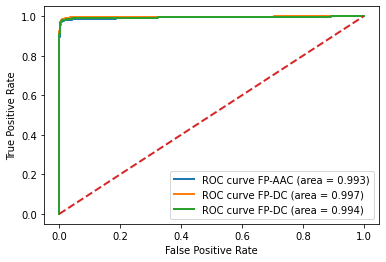

In [ ]:
plt.plot(fpr_aac, tpr_aac, lw=2, label='ROC curve FP-AAC (area = %0.3f)' % auc_aac)
plt.plot(fpr_dc, tpr_dc, lw=2, label='ROC curve FP-DC (area = %0.3f)' % auc_dc)
plt.plot(fpr_qso, tpr_qso, lw=2, label='ROC curve FP-DC (area = %0.3f)' % auc_qso)
plt.plot([0,1], [0,1], lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Testing with Test Data (Transformed and HerbalDB)

## Prepare Test Data
FP-DC

### Protein DC Feature

In [ ]:
dc = pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/prot-dc.csv')
print(dc.shape)
dc.head()

(17, 401)


,dc_1,dc_2,dc_3,dc_4,dc_5,dc_6,dc_7,dc_8,dc_9,dc_10,dc_11,dc_12,dc_13,dc_14,dc_15,dc_16,dc_17,dc_18,dc_19,dc_20,dc_21,dc_22,dc_23,dc_24,dc_25,dc_26,dc_27,dc_28,dc_29,dc_30,dc_31,dc_32,dc_33,dc_34,dc_35,dc_36,dc_37,dc_38,dc_39,dc_40,...,dc_362,dc_363,dc_364,dc_365,dc_366,dc_367,dc_368,dc_369,dc_370,dc_371,dc_372,dc_373,dc_374,dc_375,dc_376,dc_377,dc_378,dc_379,dc_380,dc_381,dc_382,dc_383,dc_384,dc_385,dc_386,dc_387,dc_388,dc_389,dc_390,dc_391,dc_392,dc_393,dc_394,dc_395,dc_396,dc_397,dc_398,dc_399,dc_400,uniprot_id
0,0.0,0.000000,0.000000,0.008475,0.000000,0.0,0.000000,0.008475,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.008475,0.002481,0.003309,0.003309,0.001654,0.003309,0.000000,0.007444,0.002481,0.000827,0.000827,0.001654,0.005790,0.000827,0.004136,0.000827,0.003309,...,0.00000,0.00000,0.0,0.000000,0.008621,0.00000,0.0,0.0,0.00000,0.004310,0.004310,0.00000,0.0,0.0,0.00431,0.00000,0.000000,0.004329,0.000000,0.000000,0.000000,0.008658,0.000000,0.004329,0.008658,0.004329,0.004329,0.000000,0.008658,0.000000,0.000000,0.0,0.004329,0.004329,0.000000,0.000000,0.000000,0.000000,0.004329,B2MG_HUMAN
1,0.0,0.008475,0.016949,0.000000,0.000000,0.0,0.008475,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.008475,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.002481,0.003309,0.003309,0.003309,0.000000,0.000827,0.007444,0.001654,0.005790,0.000827,0.000827,0.002481,0.004963,0.004136,0.001654,0.000000,...,0.00431,0.00431,0.0,0.004310,0.012931,0.00431,0.0,0.0,0.00000,0.008621,0.000000,0.00431,0.0,0.0,0.00000,0.00000,0.004329,0.000000,0.004329,0.000000,0.000000,0.008658,0.000000,0.000000,0.004329,0.000000,0.000000,0.000000,0.004329,0.012987,0.000000,0.0,0.000000,0.008658,0.000000,0.000000,0.000000,0.000000,0.008658,EGFR_HUMAN
2,0.0,0.008475,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.016949,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.008475,0.0,0.000000,0.0,0.000000,0.000000,0.004963,0.003309,0.002481,0.004963,0.002481,0.005790,0.000827,0.004963,0.002481,0.001654,0.000827,0.000827,0.004963,0.004136,0.000000,0.004136,...,0.00000,0.00431,0.0,0.012931,0.004310,0.00000,0.0,0.0,0.00431,0.000000,0.008621,0.00431,0.0,0.0,0.00431,0.00431,0.004329,0.000000,0.000000,0.004329,0.004329,0.008658,0.000000,0.004329,0.012987,0.004329,0.004329,0.004329,0.008658,0.000000,0.004329,0.0,0.004329,0.000000,0.017316,0.004329,0.004329,0.000000,0.004329,HDAC3_HUMAN
3,0.0,0.000000,0.000000,0.000000,0.016949,0.0,0.000000,0.000000,0.0,0.000000,0.008475,0.000000,0.008475,0.000000,0.000000,0.0,0.016949,0.0,0.000000,0.0,0.008475,0.0,0.000000,0.000000,0.001654,0.001654,0.007444,0.000000,0.002481,0.004963,0.001654,0.004963,0.000827,0.004136,0.002481,0.001654,0.006617,0.000000,0.000827,0.000827,...,0.00431,0.00000,0.0,0.000000,0.000000,0.00431,0.0,0.0,0.00000,0.004310,0.017241,0.00000,0.0,0.0,0.00000,0.00000,0.004329,0.000000,0.004329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004329,0.000000,0.004329,0.004329,0.008658,0.0,0.000000,0.004329,0.000000,0.000000,0.000000,0.000000,0.000000,HMOX1_HUMAN
4,0.0,0.000000,0.000000,0.008475,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.016949,0.000000,0.016949,0.000000,0.0,0.000000,0.0,0.033898,0.0,0.000000,0.0,0.008475,0.008475,0.002481,0.001654,0.001654,0.001654,0.001654,0.000827,0.006617,0.000827,0.002481,0.000827,0.003309,0.001654,0.001654,0.003309,0.003309,0.001654,...,0.00000,0.00000,0.0,0.004310,0.000000,0.00000,0.0,0.0,0.00000,0.000000,0.004310,0.00431,0.0,0.0,0.00431,0.00000,0.000000,0.000000,0.000000,0.004329,0.017316,0.004329,0.004329,0.004329,0.004329,0.008658,0.004329,0.004329,0.000000,0.004329,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.004329,0.000000,IFNG_HUMAN


In [ ]:
dc['uniprot_id']

0      B2MG_HUMAN
1      EGFR_HUMAN
2     HDAC3_HUMAN
3     HMOX1_HUMAN
4      IFNG_HUMAN
5      IL1B_HUMAN
6       IL6_HUMAN
7       IL8_HUMAN
8      LOX5_HUMAN
9     MMP12_HUMAN
10     PERM_HUMAN
11     PGH2_HUMAN
12     RASH_HUMAN
13     SDF1_HUMAN
14     TF65_HUMAN
15     TNFA_HUMAN
16    VEGFA_HUMAN
Name: uniprot_id, dtype: object

In [ ]:
# List Protein
test_uniprot = ['IL1B_HUMAN', 'IL6_HUMAN', 'IL8_HUMAN', 'IFNG_HUMAN', 'TNFA_HUMAN']
dc_test = dc[dc['uniprot_id'].isin(test_uniprot)]
print(dc_test.shape)
dc_test.head()

(5, 401)


,dc_1,dc_2,dc_3,dc_4,dc_5,dc_6,dc_7,dc_8,dc_9,dc_10,dc_11,dc_12,dc_13,dc_14,dc_15,dc_16,dc_17,dc_18,dc_19,dc_20,dc_21,dc_22,dc_23,dc_24,dc_25,dc_26,dc_27,dc_28,dc_29,dc_30,dc_31,dc_32,dc_33,dc_34,dc_35,dc_36,dc_37,dc_38,dc_39,dc_40,...,dc_362,dc_363,dc_364,dc_365,dc_366,dc_367,dc_368,dc_369,dc_370,dc_371,dc_372,dc_373,dc_374,dc_375,dc_376,dc_377,dc_378,dc_379,dc_380,dc_381,dc_382,dc_383,dc_384,dc_385,dc_386,dc_387,dc_388,dc_389,dc_390,dc_391,dc_392,dc_393,dc_394,dc_395,dc_396,dc_397,dc_398,dc_399,dc_400,uniprot_id
4,0.000000,0.000000,0.0,0.008475,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.016949,0.000000,0.016949,0.000000,0.000000,0.0,0.000000,0.033898,0.000000,0.0,0.000000,0.008475,0.008475,0.002481,0.001654,0.001654,0.001654,0.001654,0.000827,0.006617,0.000827,0.002481,0.000827,0.003309,0.001654,0.001654,0.003309,0.003309,0.001654,...,0.00000,0.00000,0.000000,0.00431,0.000000,0.00000,0.0,0.00000,0.00000,0.000000,0.004310,0.00431,0.00000,0.00000,0.004310,0.000000,0.000000,0.000000,0.000000,0.004329,0.017316,0.004329,0.004329,0.004329,0.004329,0.008658,0.004329,0.004329,0.000000,0.004329,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.004329,0.000000,IFNG_HUMAN
5,0.008475,0.000000,0.0,0.000000,0.000000,0.000000,0.008475,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.008475,0.000000,0.0,0.000000,0.008475,0.000000,0.0,0.000000,0.008475,0.000000,0.000000,0.004136,0.003309,0.000827,0.000827,0.000000,0.002481,0.000000,0.004136,0.001654,0.001654,0.011580,0.000000,0.004136,0.000827,0.001654,...,0.00431,0.00000,0.008621,0.00000,0.017241,0.00000,0.0,0.00000,0.00431,0.008621,0.004310,0.00000,0.00431,0.00431,0.008621,0.000000,0.000000,0.008658,0.004329,0.000000,0.000000,0.000000,0.004329,0.004329,0.000000,0.000000,0.000000,0.000000,0.004329,0.000000,0.000000,0.008658,0.000000,0.004329,0.000000,0.0,0.004329,0.000000,0.000000,IL1B_HUMAN
6,0.000000,0.008475,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.016949,0.0,0.0,0.000000,0.025424,0.008475,0.000000,0.000000,0.0,0.000000,0.008475,0.000000,0.0,0.000000,0.008475,0.000000,0.005790,0.001654,0.001654,0.004963,0.004136,0.004963,0.001654,0.000827,0.006617,0.000827,0.002481,0.003309,0.004963,0.001654,0.000000,0.000827,...,0.00000,0.00431,0.000000,0.00431,0.000000,0.00000,0.0,0.00000,0.00431,0.008621,0.004310,0.00431,0.00000,0.00000,0.000000,0.000000,0.000000,0.008658,0.000000,0.004329,0.000000,0.004329,0.000000,0.004329,0.008658,0.008658,0.004329,0.000000,0.000000,0.000000,0.004329,0.004329,0.008658,0.008658,0.004329,0.0,0.008658,0.000000,0.000000,IL6_HUMAN
7,0.000000,0.008475,0.0,0.000000,0.016949,0.000000,0.016949,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.008475,0.0,0.016949,0.008475,0.000000,0.0,0.008475,0.008475,0.008475,0.000827,0.002481,0.002481,0.001654,0.002481,0.003309,0.000827,0.005790,0.004136,0.000000,0.005790,0.004963,0.004136,0.002481,0.000827,0.001654,...,0.00000,0.00000,0.000000,0.00000,0.000000,0.00431,0.0,0.00431,0.00000,0.000000,0.012931,0.00431,0.00000,0.00000,0.000000,0.008621,0.000000,0.000000,0.004329,0.000000,0.008658,0.000000,0.000000,0.004329,0.000000,0.000000,0.004329,0.000000,0.004329,0.000000,0.004329,0.004329,0.008658,0.004329,0.004329,0.0,0.000000,0.000000,0.004329,IL8_HUMAN
15,0.000000,0.000000,0.0,0.000000,0.000000,0.008475,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.008475,0.000000,0.000000,0.000000,0.0,0.000000,0.008475,0.008475,0.0,0.000000,0.008475,0.002481,0.001654,0.002481,0.000000,0.001654,0.004963,0.000000,0.000000,0.004136,0.001654,0.001654,0.000827,0.012407,0.002481,0.000000,0.000827,0.000000,...,0.00000,0.00000,0.000000,0.00431,0.004310,0.00000,0.0,0.00000,0.00000,0.008621,0.000000,0.00000,0.00000,0.00000,0.004310,0.004329,0.008658,0.000000,0.000000,0.000000,0.000000,0.008658,0.000000,0.000000,0.000000,0.000000,0.004329,0.000000,0.000000,0.004329,0.004329,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.004329,TNFA_HUMAN


### Herbal Compound

In [ ]:
herbs = pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/com-test-herbaldb-final.csv')
print(herbs.shape)
herbs.head()

(811, 883)


,name,pubchemID,>=_4_H,>=_8_H,>=_16_H,>=_32_H,>=_1_Li,>=_2_Li,>=_1_B,>=_2_B,>=_4_B,>=_2_C,>=_4_C,>=_8_C,>=_16_C,>=_32_C,>=_1_N,>=_2_N,>=_4_N,>=_8_N,>=_1_O,>=_2_O,>=_4_O,>=_8_O,>=_16_O,>=_1_F,>=_2_F,>=_4_F,>=_1_Na,>=_2_Na,>=_1_Si,>=_2_Si,>=_1_P,>=_2_P,>=_4_P,>=_1_S,>=_2_S,>=_4_S,>=_8_S,>=_1_Cl,...,CC1CC(S)CC1,CC1CC(N)CC1,CC1CC(Cl)CC1,CC1CC(Br)CC1,OC1CC(O)CC1,OC1CC(S)CC1,OC1CC(N)CC1,OC1CC(Cl)CC1,OC1CC(Br)CC1,SC1CC(S)CC1,SC1CC(N)CC1,SC1CC(Cl)CC1,SC1CC(Br)CC1,NC1CC(N)CC1,NC1CC(Cl)CC1,NC1CC(Br)CC1,ClC1CC(Cl)CC1,ClC1CC(Br)CC1,BrC1CC(Br)CC1,CC1C(C)CCC1,CC1C(O)CCC1,CC1C(S)CCC1,CC1C(N)CCC1,CC1C(Cl)CCC1,CC1C(Br)CCC1,OC1C(O)CCC1,OC1C(S)CCC1,OC1C(N)CCC1,OC1C(Cl)CCC1,OC1C(Br)CCC1,SC1C(S)CCC1,SC1C(N)CCC1,SC1C(Cl)CCC1,SC1C(Br)CCC1,NC1C(N)CCC1,NC1C(Cl)CC1,NC1C(Br)CCC1,ClC1C(Cl)CCC1,ClC1C(Br)CCC1,BrC1C(Br)CCC1
0,Tubotaiwine,100004,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Isoforskolin,10001602,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,beta-phenethylamine,1001,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Limacine,100257,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,(-)-Repandine,10031631,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
herbs_list = herbs['pubchemID']
herbs_list

0         100004
1       10001602
2           1001
3         100257
4       10031631
         ...    
806    135438594
807    135438599
808    135407639
809       637858
810    135398635
Name: pubchemID, Length: 811, dtype: int64

### Create interactions

In [ ]:
5 * 811

4055

In [ ]:
proteins = []
compounds = []

for i in test_uniprot:
  for j in herbs_list:
    proteins.append(i)
    compounds.append(j)

assert len(proteins) == len(test_uniprot) * len(herbs_list)
assert len(compounds) == len(test_uniprot) * len(herbs_list)

print(len(proteins))
print(len(compounds))

4055
4055


In [ ]:
test_herbal_interactions = pd.DataFrame()
test_herbal_interactions['uniprot_id'] = proteins
test_herbal_interactions['pubchemID'] = compounds

test_herbal_interactions.to_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/test-herbal-interactions.csv', index=False)

print(test_herbal_interactions.shape)
test_herbal_interactions.head()

(4055, 2)


,uniprot_id,pubchemID
0,IL1B_HUMAN,100004
1,IL1B_HUMAN,10001602
2,IL1B_HUMAN,1001
3,IL1B_HUMAN,100257
4,IL1B_HUMAN,10031631


## Train The Best Model

In [ ]:
fp_dc = pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/train-fp-dc.csv')
fp_dc = fp_dc.drop(['uniprot_id', 'pubchemID', 'drug'], axis=1)

X = fp_dc.drop('interaction', axis=1)
y = fp_dc.interaction

scaler_all = MinMaxScaler()
X_all = pd.DataFrame(data = scaler_all.fit_transform(X), columns=X.columns)

# le = LabelEncoder()
# y = le.fit_transform(y)

res_all = [[],[],[],[],[]]
auc_plots2 = []
y_pred_proba_all = 0 ; c = 0 ; cv_count = 10
sae_weights = sae_model(xt=X_all, xv=X.astype(float), EPOCHS=100, af="sigmoid", lr=1e-05, num_layers=2, hl_node=1250, BATCH_SIZE=32, opt="adam", do=0.1, fr_node=0.5)

# Initiate Cross-Validation
cv = StratifiedKFold(n_splits=cv_count, random_state=42, shuffle=True)
# Fold 8 => Index 8 - 1 = 7
i = 0
for train_ind, test_ind in cv.split(X,y):
  if i == 7:
    #Train the model
    X_train,y_train = X.iloc[train_ind,:],y[train_ind]
    X_test,y_test = X.iloc[test_ind,:],y[test_ind]

    #Data splitting, labelling, and normalizing
    le = LabelEncoder()
    y = le.fit_transform(y)
    scaler = MinMaxScaler()
    X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
    X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)

    #Fitting model
    sae_dnn =dnn_model(xt=X_train_mm, sae_weights=sae_weights, EPOCHS=100, af="sigmoid", lr=1e-05, num_layers=2, hl_node=1250, BATCH_SIZE=32, opt="adam", do=0.1, fr_node=0.5)
    es = EarlyStopping(monitor='val_loss', patience=25)
    sae_dnn.fit(X_train_mm, y_train, epochs=100, batch_size=32, verbose=False)

    #Predict
    y_pred_proba = sae_dnn.predict(X_test_mm)
    y_pred = [1 if elem >= 0.5 else 0 for elem in y_pred_proba]
    # y_pred_proba_all += y_pred_proba

    #Calculate metrics
    accu = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, y_pred, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, y_pred, average='binary',pos_label=0)

    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc_plots2.append([fpr,tpr,auc])
    #Show metrics
    print("Accuracy  : {:.3f}".format(accu))
    print("Recall    : {:.3f}".format(recall_score))
    print("Precision : {:.3f}".format(precision_score))
    print("ROC-AUC   : {:.3f}".format(auc))
    print("F1_Score  : {:.3f}".format(f1_score))
    print(confusion_matrix(y_test,y_pred))
    print("===================================")
    print("===================================")

    i = i + 1
  else:
    i = i + 1

# #Average and Stdv of k-fold CV
# print('Average Result of {} CV'.format(cv_count))
# print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
# print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
# print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
# print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
# print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
# print('===================================')

#Save CV result and choose auc plot with highest score
best_auc_acd = auc_plots2[np.array(res_all[3]).argmax()]
res_all_acd = res_all

Accuracy  : 0.990
Recall    : 0.968
Precision : 0.971
ROC-AUC   : 0.997
F1_Score  : 0.970
[[3928   23]
 [  25  765]]


In [ ]:
sae_dnn.save('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/asset/model-sae-dnn')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/asset/model-sae-dnn/assets


## Get The Result

### Combine Test Herbal Dataset

In [ ]:
400 + 881

1281

In [ ]:
test_herbal_interactions = pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/test-herbal-interactions.csv')
test_herbal_interactions.head()

NameError: ignored

In [ ]:
test_herbal_interactions = pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/test-herbal-interactions.csv')
dc = pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/prot-dc.csv')
herbs = pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/com-test-herbaldb-final.csv')

test_herbal_fp_dc = test_herbal_interactions.merge(dc, on='uniprot_id')
test_herbal_fp_dc = test_herbal_fp_dc.merge(herbs, on='pubchemID')
test_herbal_fp_dc = test_herbal_fp_dc.drop_duplicates()
test_interactions = test_herbal_fp_dc[['uniprot_id', 'pubchemID', 'name']]
test_herbal_fp_dc = test_herbal_fp_dc.drop(['uniprot_id', 'pubchemID', 'name'], axis=1)

test_herbal_fp_dc.to_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/test-herbal-fp-dc.csv', index=False)

# Ekspektasi baris: 4055
print(test_herbal_fp_dc.shape)
test_herbal_fp_dc.head()

(4055, 1281)


,dc_1,dc_2,dc_3,dc_4,dc_5,dc_6,dc_7,dc_8,dc_9,dc_10,dc_11,dc_12,dc_13,dc_14,dc_15,dc_16,dc_17,dc_18,dc_19,dc_20,dc_21,dc_22,dc_23,dc_24,dc_25,dc_26,dc_27,dc_28,dc_29,dc_30,dc_31,dc_32,dc_33,dc_34,dc_35,dc_36,dc_37,dc_38,dc_39,dc_40,...,CC1CC(S)CC1,CC1CC(N)CC1,CC1CC(Cl)CC1,CC1CC(Br)CC1,OC1CC(O)CC1,OC1CC(S)CC1,OC1CC(N)CC1,OC1CC(Cl)CC1,OC1CC(Br)CC1,SC1CC(S)CC1,SC1CC(N)CC1,SC1CC(Cl)CC1,SC1CC(Br)CC1,NC1CC(N)CC1,NC1CC(Cl)CC1,NC1CC(Br)CC1,ClC1CC(Cl)CC1,ClC1CC(Br)CC1,BrC1CC(Br)CC1,CC1C(C)CCC1,CC1C(O)CCC1,CC1C(S)CCC1,CC1C(N)CCC1,CC1C(Cl)CCC1,CC1C(Br)CCC1,OC1C(O)CCC1,OC1C(S)CCC1,OC1C(N)CCC1,OC1C(Cl)CCC1,OC1C(Br)CCC1,SC1C(S)CCC1,SC1C(N)CCC1,SC1C(Cl)CCC1,SC1C(Br)CCC1,NC1C(N)CCC1,NC1C(Cl)CC1,NC1C(Br)CCC1,ClC1C(Cl)CCC1,ClC1C(Br)CCC1,BrC1C(Br)CCC1
0,0.008475,0.000000,0.0,0.000000,0.000000,0.000000,0.008475,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.008475,0.000000,0.0,0.000000,0.008475,0.000000,0.0,0.000000,0.008475,0.000000,0.000000,0.004136,0.003309,0.000827,0.000827,0.000000,0.002481,0.000000,0.004136,0.001654,0.001654,0.011580,0.000000,0.004136,0.000827,0.001654,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.000000,0.008475,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.016949,0.0,0.0,0.000000,0.025424,0.008475,0.000000,0.000000,0.0,0.000000,0.008475,0.000000,0.0,0.000000,0.008475,0.000000,0.005790,0.001654,0.001654,0.004963,0.004136,0.004963,0.001654,0.000827,0.006617,0.000827,0.002481,0.003309,0.004963,0.001654,0.000000,0.000827,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.000000,0.008475,0.0,0.000000,0.016949,0.000000,0.016949,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.008475,0.0,0.016949,0.008475,0.000000,0.0,0.008475,0.008475,0.008475,0.000827,0.002481,0.002481,0.001654,0.002481,0.003309,0.000827,0.005790,0.004136,0.000000,0.005790,0.004963,0.004136,0.002481,0.000827,0.001654,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.000000,0.0,0.008475,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.016949,0.000000,0.016949,0.000000,0.000000,0.0,0.000000,0.033898,0.000000,0.0,0.000000,0.008475,0.008475,0.002481,0.001654,0.001654,0.001654,0.001654,0.000827,0.006617,0.000827,0.002481,0.000827,0.003309,0.001654,0.001654,0.003309,0.003309,0.001654,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.000000,0.0,0.000000,0.000000,0.008475,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.008475,0.000000,0.000000,0.000000,0.0,0.000000,0.008475,0.008475,0.0,0.000000,0.008475,0.002481,0.001654,0.002481,0.000000,0.001654,0.004963,0.000000,0.000000,0.004136,0.001654,0.001654,0.000827,0.012407,0.002481,0.000000,0.000827,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(test_interactions.shape)
test_interactions.head()

(4055, 3)


,uniprot_id,pubchemID,name
0,IL1B_HUMAN,100004,Tubotaiwine
1,IL6_HUMAN,100004,Tubotaiwine
2,IL8_HUMAN,100004,Tubotaiwine
3,IFNG_HUMAN,100004,Tubotaiwine
4,TNFA_HUMAN,100004,Tubotaiwine


### NOW PREDICT

In [ ]:
y_pred_herbal_proba = sae_dnn.predict(test_herbal_fp_dc)
print(y_pred_herbal_proba.shape)
print(y_pred_herbal_proba[:20])

(4055, 1)
[[0.1725707 ]
 [0.17937335]
 [0.17988451]
 [0.16934673]
 [0.17615467]
 [0.8172415 ]
 [0.8178511 ]
 [0.8186025 ]
 [0.8151627 ]
 [0.8200695 ]
 [0.9322366 ]
 [0.93303823]
 [0.9323683 ]
 [0.9297614 ]
 [0.93547916]
 [0.07898665]
 [0.07923834]
 [0.0764762 ]
 [0.0773632 ]
 [0.08168028]]


In [ ]:
test_interactions['interaction_prob'] = y_pred_herbal_proba.flatten()
test_interactions['interaction'] = [1 if i >= 0.5 else 0 for i in y_pred_herbal_proba.flatten()]
print(test_interactions.shape)
test_interactions.head()

(4055, 5)


,uniprot_id,pubchemID,name,interaction_prob,interaction
0,IL1B_HUMAN,100004,Tubotaiwine,0.172571,0
1,IL6_HUMAN,100004,Tubotaiwine,0.179373,0
2,IL8_HUMAN,100004,Tubotaiwine,0.179885,0
3,IFNG_HUMAN,100004,Tubotaiwine,0.169347,0
4,TNFA_HUMAN,100004,Tubotaiwine,0.176155,0


In [ ]:
test_interactions['interaction'].value_counts()

0    2772
1    1283
Name: interaction, dtype: int64

In [ ]:
test_interactions.to_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/final-result-1.csv', index=False)

In [ ]:
import pandas as pd
pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/final-result-1.csv').groupby(['uniprot_id', 'interaction']).count()

pubchemID  name  interaction_prob
uniprot_id interaction                                   
IFNG_HUMAN 0                  559   559               559
           1                  252   252               252
IL1B_HUMAN 0                  554   554               554
           1                  257   257               257
IL6_HUMAN  0                  554   554               554
           1                  257   257               257
IL8_HUMAN  0                  554   554               554
           1                  257   257               257
TNFA_HUMAN 0                  551   551               551
           1                  260   260               260

In [ ]:
test_interactions.groupby(['uniprot_id', 'interaction']).count()

pubchemID  name  interaction_prob
uniprot_id interaction                                   
IFNG_HUMAN 0                  778   778               778
           1                   33    33                33
IL1B_HUMAN 0                  778   778               778
           1                   33    33                33
IL6_HUMAN  0                  778   778               778
           1                   33    33                33
IL8_HUMAN  0                  778   778               778
           1                   33    33                33
TNFA_HUMAN 0                  778   778               778
           1                   33    33                33

In [ ]:
drug_candidates = test_interactions[test_interactions['interaction'] == 1]

In [ ]:
drug_candidates['name'].unique()

array(['Perseitol', 'Quinidine', 'Chamazulene', 'Spermidine', 'Dulcitol',
       'Nonacosane', 'Hentriacontan', 'Tritriacontane',
       'Isopropylcyclohexane', 'Diallyl disulfide', 'Agmatine', 'Glucose',
       'Cinchonidine', 'Choline', 'Citric acid', 'Pimelic acid',
       '(+)-Quercitol', '(-)-Viburnitol', '(-)-Apparicine', 'Fructose',
       'L-Histidine', 'Pseudoakuammigine', 'Allicin', 'Glucobrassicin',
       'Picrinine', 'Glyoxylic acid', 'Quinine', 'Cinchonine',
       '(-)-Pelletierine', 'D-Arabitol', 'Hentriacontan-16-one',
       'Oxalic acid', 'L-(+)-Tartaric acid'], dtype=object)

In [ ]:
drug_candidates[drug_candidates['uniprot_id'] == 'IL6_HUMAN'].sort_values('interaction_prob', ascending=False)

,uniprot_id,pubchemID,name,interaction_prob,interaction
1216,IL6_HUMAN,24749,Glucose,0.998842,1
3176,IL6_HUMAN,5984,Fructose,0.998198,1
4166,IL6_HUMAN,94154,D-Arabitol,0.997029,1
1431,IL6_HUMAN,311,Citric acid,0.996192,1
421,IL6_HUMAN,11850,Dulcitol,0.994431,1
106,IL6_HUMAN,101748,Perseitol,0.993770,1
4311,IL6_HUMAN,444305,L-(+)-Tartaric acid,0.993619,1
306,IL6_HUMAN,1102,Spermidine,0.993179,1
4106,IL6_HUMAN,90454,Cinchonine,0.990241,1
1361,IL6_HUMAN,3035282,Cinchonidine,0.989281,1


In [ ]:
drug_candidates[drug_candidates['uniprot_id'] == 'TNFA_HUMAN'].sort_values('interaction_prob', ascending=False)

,uniprot_id,pubchemID,name,interaction_prob,interaction
1219,TNFA_HUMAN,24749,Glucose,0.998917,1
3179,TNFA_HUMAN,5984,Fructose,0.998328,1
4169,TNFA_HUMAN,94154,D-Arabitol,0.997240,1
1434,TNFA_HUMAN,311,Citric acid,0.996400,1
424,TNFA_HUMAN,11850,Dulcitol,0.994868,1
109,TNFA_HUMAN,101748,Perseitol,0.994202,1
4314,TNFA_HUMAN,444305,L-(+)-Tartaric acid,0.994046,1
309,TNFA_HUMAN,1102,Spermidine,0.993302,1
4109,TNFA_HUMAN,90454,Cinchonine,0.990180,1
1364,TNFA_HUMAN,3035282,Cinchonidine,0.989221,1


In [ ]:
drug_candidates['uniprot_id'].unique()

array(['IL1B_HUMAN', 'IL6_HUMAN', 'IL8_HUMAN', 'IFNG_HUMAN', 'TNFA_HUMAN'],
      dtype=object)

# OTHER

In [ ]:
#Train model
sae_weights = sae_model(xt = X_all, xv = X_train_rus_mm.astype(float), EPOCHS = 100, af = "relu", lr=0.01, num_layers = 2, hl_node= 300, BATCH_SIZE=32, opt = "adam", do = 0.5)
sae_dnn = dnn_model(xt = X_train_rus_mm, sae_weights = sae_weights, EPOCHS = 100, af = "relu", lr=0.01, num_layers = 2, hl_node= 300, BATCH_SIZE=32, opt = "adam", do = 0.5)
sae_dnn.fit(X_train_mm,y_train,epochs=100,batch_size=32,verbose = False)

In [ ]:
#Predict result
y_pred_proba = sae_dnn.predict(X_test_rus_mm)
y_pred = [1 if elem >= 0.5 else 0 for elem in y_pred_proba]
Counter(y_pred)

In [ ]:
#Make dataframe from result
X_test_dti = X_test_rus[["CID_senyawa","Protein"]].copy()
X_test_dti["Probability"] = pd.Series(y_pred_proba.flatten())
X_test_res = pd.merge(X_test_dti, cov_dti[["CID_senyawa", "Senyawa"]].drop_duplicates(), on = "CID_senyawa", how = "inner").drop_duplicates(subset = ["CID_senyawa","Protein"], keep = "first"	 ).reset_index(drop = True)
X_test_res[(X_test_res["Protein"].isin(cov19_prot)) & (X_test_res["Probability"] >= 0.5)].sort_values(by = "Probability", ascending = False).head(15)

In [ ]:
Counter(X_test_res[(X_test_res["Protein"].isin(cov19_prot)) & (X_test_res["Probability"] >= 0.5)]["Protein"])